# Phi3 mini 4k

importation pour utilisation avec HF

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/models/phi 3 mini 4k")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/models/phi 3 mini 4k")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
messages = [{"role": "user", "content": "Can you provide ways to eat combinations of bananas and dragonfruits?"}]
inputs = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")

outputs = model.generate(inputs, max_new_tokens=32)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
You are not running the flash-attention implementation, expect numerical differences.


<|user|> Can you provide ways to eat combinations of bananas and dragonfruits?<|end|><|assistant|> Certainly! Bananas and dragonfruits can be combined in various delicious ways. Here are some creative ideas for incorporating both fruits


In [ ]:
prompt = "Bonjour"
inputs = tokenizer(prompt, return_tensors="pt")

# Generate
generate_ids = model.generate(inputs.input_ids, max_length=30)
tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

"Bonjour, je suis un assistant virtuel développé par Microsoft. Comment puis-je vous aider aujourd'hui ?\n\n\n###"

# SelfCheckGPT


---

| Benchmark            	| Citation                         	| Datasets 	| Data Size 	| Language 	| Factuality 	| Faithfulness 	| Manual 	| Task Type 	| Input               	| Label   	| Metric 	| Dataset available ? 	| Code available ? 	| Needs API Key ? 	| Dataset Link                                                         	| Code Link                                	|
|----------------------	|----------------------------------	|----------	|-----------	|----------	|:----------:	|:------------:	|:------:	|-----------	|---------------------	|---------	|--------	|:-------------------:	|:----------------:	|:---------------:	|----------------------------------------------------------------------	|------------------------------------------	|
| SelfCheckGPT-Wikibio 	| https://arxiv.org/abs/2303.08896 	| -        	|     1,908 	| English  	|      ❌     	|       ✅      	|    ❌   	| Detection 	| Paragraph & Concept 	| Passage 	| AUROC  	|          ✅          	|         ✅        	|        ❌        	| https://huggingface.co/datasets/potsawee/wiki_bio_gpt3_hallucination 	| https://github.com/potsawee/selfcheckgpt 	|

## Initialisation

In [ ]:
pip install selfcheckgpt

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

In [ ]:
import torch, spacy

In [ ]:
# Include necessary packages (torch, spacy, ...)
from selfcheckgpt.modeling_selfcheck import SelfCheckMQAG, SelfCheckBERTScore, SelfCheckNgram
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SelfCheck-BERTScore initialized
SelfCheck-1gram initialized


## Test from original repo

### test text

In [ ]:
# LLM's text (e.g. GPT-3 response) to be evaluated at the sentence level  & Split it into sentences
passage = "Michael Alan Weiner (born March 31, 1942) is an American radio host. He is the host of The Savage Nation."
nlp = spacy.load("en_core_web_sm")
sentences = [sent.text.strip() for sent in nlp(passage).sents] # spacy sentence tokenization
print(sentences)
['Michael Alan Weiner (born March 31, 1942) is an American radio host.', 'He is the host of The Savage Nation.']

# Other samples generated by the same LLM to perform self-check for consistency
sample1 = "Michael Alan Weiner (born March 31, 1942) is an American radio host. He is the host of The Savage Country."
sample2 = "Michael Alan Weiner (born January 13, 1960) is a Canadian radio host. He works at The New York Times."
sample3 = "Michael Alan Weiner (born March 31, 1942) is an American radio host. He obtained his PhD from MIT."

['Michael Alan Weiner (born March 31, 1942) is an American radio host.', 'He is the host of The Savage Nation.']


### SelfCheckGPT Usage: BERTScore, QA, n-gram

There are three variants of SelfCheck scores in this package as described in the paper:
* SelfCheckBERTScore()
* SelfCheckMQAG()
* SelfCheckNgram().

All of the variants have predict() which will output the sentence-level scores w.r.t. sampled passages. You can use packages such as spacy to split passage into sentences. For reproducibility, you can set torch.manual_seed before calling this function. See more details in Jupyter Notebook demo/SelfCheck_demo1.ipynb

#### SelfCheck-MQAG

Score for each sentence where value is in [0.0, 1.0] and high value means non-factual


 Additional params for each scoring_method:
 * counting: AT (answerability threshold, i.e. questions with answerability_score < AT are rejected)
 * bayes: AT, beta1, beta2
 * bayes_with_alpha: beta1, beta2

In [ ]:
# --------------------------------------------------------------------------------------------------------------- #
# SelfCheck-MQAG: Score for each sentence where value is in [0.0, 1.0] and high value means non-factual
selfcheck_mqag = SelfCheckMQAG(device=device) # set device to 'cuda' if GPU is available
# Additional params for each scoring_method:
# -> counting: AT (answerability threshold, i.e. questions with answerability_score < AT are rejected)
# -> bayes: AT, beta1, beta2
# -> bayes_with_alpha: beta1, beta2

sent_scores_mqag = selfcheck_mqag.predict(
    sentences = sentences,               # list of sentences
    passage = passage,                   # passage (before sentence-split)
    sampled_passages = [sample1, sample2, sample3], # list of sampled passages
    num_questions_per_sent = 5,          # number of questions to be drawn
    scoring_method = 'bayes_with_alpha', # options = 'counting', 'bayes', 'bayes_with_alpha'
    beta1 = 0.8, beta2 = 0.8,            # additional params depending on scoring_method
)

SelfCheck-MQAG initialized to device cpu
[0.27892719 0.40812035]
SelfCheck-BERTScore initialized
[0.05884949 0.53198765]
SelfCheck-1gram initialized
{'sent_level': {'avg_neg_logprob': [3.184312427726157, 3.279774864365169], 'max_neg_logprob': [3.4760986898352733, 4.574710978503383]}, 'doc_level': {'avg_neg_logprob': 3.218678904916201, 'avg_max_neg_logprob': 4.025404834169328}}


In [ ]:
print(sent_scores_mqag)
# [0.30990949 0.42376232]

#### SelfCheck-BERTScore

Score for each sentence where value is in [0.0, 1.0] and high value means non-factual

In [ ]:
# --------------------------------------------------------------------------------------------------------------- #
# SelfCheck-BERTScore: Score for each sentence where value is in [0.0, 1.0] and high value means non-factual

selfcheck_bertscore = SelfCheckBERTScore(rescale_with_baseline=True)
sent_scores_bertscore = selfcheck_bertscore.predict(
    sentences = sentences,                          # list of sentences
    sampled_passages = [sample1, sample2, sample3], # list of sampled passages
)

In [ ]:
print(sent_scores_bertscore)
# [0.0695562  0.45590915]

#### SelfCheck-Ngram

Score at sentence- and document-level where value is in [0.0, +inf) and high value means non-factual as opposed to SelfCheck-MQAG and SelfCheck-BERTScore, SelfCheck-Ngram's score is not bounded

In [ ]:
# --------------------------------------------------------------------------------------------------------------- #
# SelfCheck-Ngram: Score at sentence- and document-level where value is in [0.0, +inf) and high value means non-factual
# as opposed to SelfCheck-MQAG and SelfCheck-BERTScore, SelfCheck-Ngram's score is not bounded
selfcheck_ngram = SelfCheckNgram(n=1) # n=1 means Unigram, n=2 means Bigram, etc.
sent_scores_ngram = selfcheck_ngram.predict(
    sentences = sentences,
    passage = passage,
    sampled_passages = [sample1, sample2, sample3],
)
print(sent_scores_ngram)
# {'sent_level': { # sentence-level score similar to MQAG and BERTScore variant
#     'avg_neg_logprob': [3.184312, 3.279774],
#     'max_neg_logprob': [3.476098, 4.574710]
#     },
#  'doc_level': {  # document-level score such that avg_neg_logprob is computed over all tokens
#     'avg_neg_logprob': 3.218678904916201,
#     'avg_max_neg_logprob': 4.025404834169327
#     }
# }

### SelfCheckGPT Usage: NLI (recommended)

Entailment (or Contradiction) score with input being the sentence and a sampled passage can be used as the selfcheck score. We use DeBERTa-v3-large fine-tuned to Multi-NLI, and we normalize the probability of "entailment" or "contradiction" classes, and take Prob(contradiction) as the score.

In [ ]:
from selfcheckgpt.modeling_selfcheck import SelfCheckNLI
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
selfcheck_nli = SelfCheckNLI(device=device) # set device to 'cuda' if GPU is available

sent_scores_nli = selfcheck_nli.predict(
    sentences = sentences,                          # list of sentences
    sampled_passages = [sample1, sample2, sample3], # list of sampled passages
)

tokenizer_config.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

SelfCheck-NLI initialized to device cpu
[0.33401404 0.97510594]


In [ ]:
print(sent_scores_nli)
# [0.334014 0.975106 ] -- based on the example above

[0.33401404 0.97510594]


### SelfCheckGPT Usage: LLM Prompt

Prompting an LLM (Llama2, Mistral, OpenAI's GPT) to assess information consistency in a zero-shot setup. We query an LLM to assess whether the i-th sentence is supported by the sample (as the context). Similar to other methods, a higher score indicates higher chance of being hallucination. An example when using Mistral is below:

In [ ]:
# Option1: open-source model
from selfcheckgpt.modeling_selfcheck import SelfCheckLLMPrompt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
llm_model = "mistralai/Mistral-7B-Instruct-v0.2"
selfcheck_prompt = SelfCheckLLMPrompt(llm_model, device)

In [ ]:
# Option2: API access
# (currently only support OpenAI and Groq)
# from selfcheckgpt.modeling_selfcheck_apiprompt import SelfCheckAPIPrompt
# selfcheck_prompt = SelfCheckAPIPrompt(client_type="openai", model="gpt-3.5-turbo")
# selfcheck_prompt = SelfCheckAPIPrompt(client_type="groq", model="llama3-70b-8192", api_key="your-api-key")

In [ ]:
sent_scores_prompt = selfcheck_prompt.predict(
    sentences = sentences,                          # list of sentences
    sampled_passages = [sample1, sample2, sample3], # list of sampled passages
    verbose = True, # whether to show a progress bar
)

In [ ]:
print(sent_scores_prompt)
# [0.33333333, 0.66666667] -- based on the example above

### Dataset

The wiki_bio_gpt3_hallucination dataset currently consists of 238 annotated passages (v3). You can find more information in the paper or our data card on HuggingFace: https://huggingface.co/datasets/potsawee/wiki_bio_gpt3_hallucination. To use this dataset, you can either load it through HuggingFace dataset API, or download it directly from below in the JSON format.

from huggingface:

In [ ]:
#from datasets import load_dataset
#dataset = load_dataset("potsawee/wiki_bio_gpt3_hallucination")

Local:

In [ ]:
import json
with open("/content/drive/MyDrive/datasets/wiki_bio_gpt3_hallucination/dataset_v3.json", "r") as f:
    content = f.read()
dataset = json.loads(content)

In [ ]:
dataset[0].keys()

dict_keys(['gpt3_text', 'wiki_bio_text', 'gpt3_sentences', 'annotation', 'wiki_bio_test_idx', 'gpt3_text_samples'])

In [ ]:
dataset[0]["gpt3_text"]

"John Russell Reynolds (1820–1876) was an English lawyer, judge, and author. He was born in London, the son of a barrister, and was educated at Eton College and Trinity College, Cambridge. He was called to the bar in 1845, and became a Queen's Counsel in 1859. He was appointed a judge of the Court of Common Pleas in 1867, and was knighted in 1871.\n\nReynolds was a prolific author, writing on a wide range of topics. He wrote several books on legal topics, including The Law of Libel and Slander (1863), The Law of Copyright (1865), and The Law of Patents for Inventions (1868). He also wrote on a variety of other topics, including history, biography, and literature. He was a frequent contributor to the Saturday Review, and wrote several books on Shakespeare, including The Mystery of William Shakespeare (1848) and The Authorship of Shakespeare (1875). He also wrote a biography of the poet John Keats (1848)."

In [ ]:
dataset[0]["wiki_bio_text"]

'Sir John Russell Reynolds, 1st Baronet (22 May 1828 – 29 May 1896) was a British neurologist and physician. Reynolds was born in Romsey, Hampshire, as the son of John Reynolds, an independent minister, and the grandson of Dr. Henry Revell Reynolds. He received general education from his father, and was educated in his profession at University College, London, where he obtained three gold medals in the medical school. In 1851, he graduated M.B. in the University of London, and obtained a scholarship and gold medal in medicine. In 1852, he took the degree of M.D., and began practice in Leeds. He soon after moved to London, and took a house, 38 Grosvenor Street, in which Dr. Marshall Hall had lived. Hall announced to his patients in a printed circular that Reynolds had succeeded him in practice. Such procedure was contrary to a recognised understanding among physicians, and Hall incurred the censure of the College of Physicians. Reynolds, who was ignorant of Hall\'s intention, was in no 

In [ ]:
dataset[0]["gpt3_sentences"]


['John Russell Reynolds (1820–1876) was an English lawyer, judge, and author.',
 'He was born in London, the son of a barrister, and was educated at Eton College and Trinity College, Cambridge.',
 "He was called to the bar in 1845, and became a Queen's Counsel in 1859.",
 'He was appointed a judge of the Court of Common Pleas in 1867, and was knighted in 1871.',
 'Reynolds was a prolific author, writing on a wide range of topics.',
 'He wrote several books on legal topics, including The Law of Libel and Slander (1863), The Law of Copyright (1865), and The Law of Patents for Inventions (1868).',
 'He also wrote on a variety of other topics, including history, biography, and literature.',
 'He was a frequent contributor to the Saturday Review, and wrote several books on Shakespeare, including The Mystery of William Shakespeare (1848) and The Authorship of Shakespeare (1875).',
 'He also wrote a biography of the poet John Keats (1848).']

### Experiments

# HaluEval

| Benchmark 	| Citation                         	| Datasets      	| Data Size 	| Language 	| Factuality 	| Faithfulness 	| Manual 	| Task Type 	| Input      	| Label    	| Metric 	| Dataset available ? 	| Code available ? 	| Needs API Key ? 	| Dataset Link                                        	| Code Link                                      	|
|-----------	|----------------------------------	|---------------	|-----------	|----------	|:----------:	|:------------:	|:------:	|-----------	|------------	|----------	|--------	|:-------------------:	|:----------------:	|:---------------:	|-----------------------------------------------------	|------------------------------------------------	|
| HaluEval  	| https://arxiv.org/abs/2305.11747 	| Task-specific 	|        30 	| English  	|      ❌     	|       ✅      	|    ❌   	| Detection 	| Query      	| Response 	| Acc    	|          ✅          	|         ✅        	|        ❌        	| https://github.com/RUCAIBox/HaluEval/tree/main/data 	| https://github.com/RUCAIBox/HaluEval/tree/main 	|
|           	|                                  	| General       	|         5 	| English  	|      ❌     	|       ✅      	|    ❌   	| Detection 	| Task Input 	| Response 	| Acc    	|          ✅          	|         ✅        	|        ❌        	| https://github.com/RUCAIBox/HaluEval/tree/main/data 	| https://github.com/RUCAIBox/HaluEval/tree/main 	|



---



---
## QA_Data shape:
|                     knowledge                    	| question 	| right_answer 	| hallucinated_answer 	|
|:------------------------------------------------:	|:--------:	|:------------:	|:-------------------:	|
| connaissances sur lesquelles est basé la réponse 	|          	| 1 answer     	| 1 hal answer        	|

## dialogue_data shape:
|                     knowledge                    	| dialogue_history 	| right_response 	| hallucinated_response 	|
|:------------------------------------------------:	|:----------------:	|:--------------:	|:---------------------:	|
| connaissances sur lesquelles est basé la réponse 	|                  	| 1 answer       	| 1 hal answer          	|

## summarization_data shape:
|      document      	| right_summary 	| hallucinated_summary 	|
|:------------------:	|:-------------:	|:--------------------:	|
| document à résumer 	| 1 summary     	| 1 hal summary        	|

## general_data shape:
| ID 	|      user_query 	| chatgpt_response 	|                hallucination 	|       hallucination_spans 	|
|---:	|----------------:	|-----------------:	|-----------------------------:	|--------------------------:	|
|    	| general queries 	| 1 summary        	| [yes, no] annoté par humains 	| span of the hallucination 	|

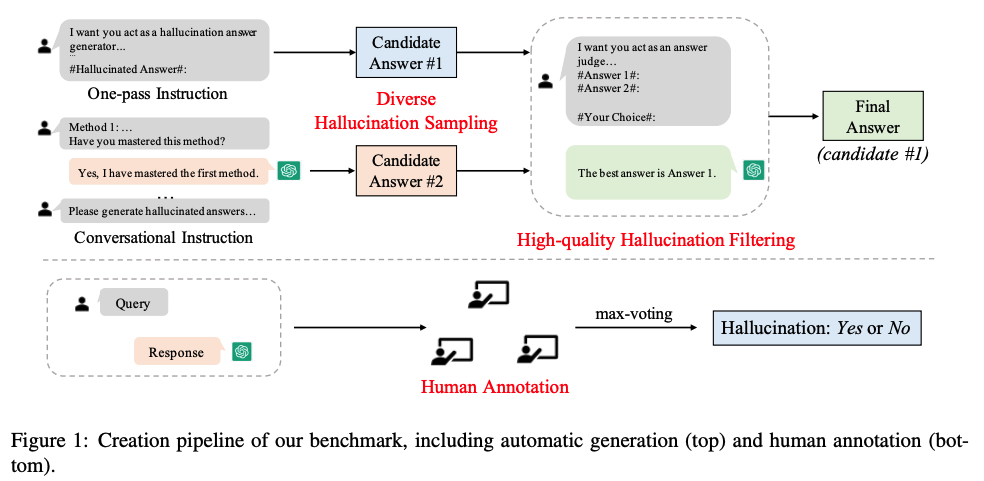

## Data used for evaluaitng the LLM

**qa_data.json**: 10K hallucinated samples for QA based on HotpotQA as seed data. For each sample dictionary, the fields knowledge, question, and right_answer refer to the knowledge from Wikipedia, question text, and ground-truth answer collected from HotpotQA. The field hallucinated_answer is the generated hallucinated answer correspondingly.

In [ ]:
import json
dataset = []
with open('/content/drive/MyDrive/datasets/HaluEval/qa_data.json', 'r') as file:
    for line in file:
        dataset.append(json.loads(line))

In [ ]:
import pandas as pd
pd.DataFrame(dataset)

,knowledge,question,right_answer,hallucinated_answer
0,Arthur's Magazine (1844–1846) was an American ...,Which magazine was started first Arthur's Maga...,Arthur's Magazine,First for Women was started first.
1,The Oberoi family is an Indian family that is ...,The Oberoi family is part of a hotel company t...,Delhi,The Oberoi family's hotel company is based in ...
2,"Allison Beth ""Allie"" Goertz (born March 2, 199...",Musician and satirist Allie Goertz wrote a son...,President Richard Nixon,"Allie Goertz wrote a song about Milhouse, a po..."
3,"Margaret ""Peggy"" Seeger (born June 17, 1935) i...",What nationality was James Henry Miller's wife?,American,James Henry Miller's wife was British.
4,It is a hygroscopic solid that is highly solu...,Cadmium Chloride is slightly soluble in this c...,alcohol,water with a hint of alcohol
...,...,...,...,...
9995,James Norman Hall (22 April 1887 – 5 July 1951...,Are James Norman Hall and Amiri Baraka from th...,yes,James Norman Hall was French.
9996,Love in the Time of Money is a 2002 American r...,The actress who appeared in the 2002 film Love...,1979,The actress who appeared in the 2002 film Love...
9997,"Ape Escape, known in Japan as Excited Saru Get...",how is Ape Escape and Nicktoons Film Festival ...,shorts,Ape Escape and Nicktoons Film Festival are con...
9998,"An accomplished full-forward, Capper kicked 3...",What position did both Warwick Capper and John...,full forward,Warwick Capper played midfield.


**dialogue_data.json**: 10K hallucinated samples for dialogue based on OpenDialKG as seed data. For each sample dictionary, the fields knowledge, dialogue_history, and right_response refer to the knowledge from Wikipedia, dialogue history, and ground-truth response collected from OpenDialKG. The field hallucinated_response is the generated hallucinated response correspondingly.

In [ ]:
import json
dataset = []
with open('/content/drive/MyDrive/datasets/HaluEval/dialogue_data.json', 'r') as file:
    for line in file:
        dataset.append(json.loads(line))

In [ ]:
import pandas as pd
pd.DataFrame(dataset)

,knowledge,dialogue_history,right_response,hallucinated_response
0,Iron Man is starring Robert Downey Jr.Robert D...,[Human]: Do you like Iron Man [Assistant]: Sur...,I like crime fiction! Didn't know RDJ was in t...,"I'm not a fan of crime movies, but I did know ..."
1,The Secret Life of Bees has genre Teen drama. ...,[Human]: Could you recommend any books like Th...,yes and he also produced White Oleander and it...,"No, I don't think Hunt Lowry was involved in A..."
2,Michael Jackson wrote Dancing the DreamDancing...,[Human]: Do you like Michael Jackson? [Assista...,"Yes, Healing the World is one of my favorite s...",Absolutely. In addition to winning the Grammy ...
3,Dead to the World is written by Charlaine Harris,[Human]: Could you recommend books similar to ...,Do you like this book because of it's author C...,Do you like this book because of its author St...
4,Ryan Reynolds starred in TurboTurbo is starrin...,[Human]: Could you recommend a good movie with...,Yep. As well as Ben Schwartz,"Actually, Snoop Dog wasn't in Turbo. But you s..."
...,...,...,...,...
9995,Lionel Messi : `~Player statistics`: Argentina...,[Human]: Do you know soccer player Lionel Mess...,I am not a big soccer fan so I don't know much...,Lionel Messi is actually a well-known basketba...
9996,Carrie has genre Romance Film,[Human]: I like Carrie. Could you recommend a ...,I can tell you some more romance titles like W...,"I'm sorry, I cannot generate a hallucinated re..."
9997,L.M. Montgomery wrote The Blue CastleThe Blue ...,[Human]: What could you recommend by L.M. Mont...,In 1926,In 1928
9998,Marco Reus : `Sport played`: Football,[Human]: I like Marco Reus do you? [Assistant]...,I like hockey and baseball. How about you?,I like basketball and swimming. How about you?


**summarization_data**.json: 10K hallucinated samples for summarization based on CNN/Daily Mail as seed data. For each sample dictionary, the fields document and right_summary refer to the document and ground-truth summary collected from CNN/Daily Mail. The field hallucinated_summary is the generated hallucinated summary correspondingly.

In [ ]:
import json
dataset = []
with open('/content/drive/MyDrive/datasets/HaluEval/summarization_data.json', 'r') as file:
    for line in file:
        dataset.append(json.loads(line))

In [ ]:
import pandas as pd
pd.DataFrame(dataset)

,document,right_summary,hallucinated_summary
0,"Marseille, France (CNN)The French prosecutor l...","Marseille prosecutor says ""so far no videos we...",A video showing the final moments of Germanwin...
1,The Palestinian Authority officially became th...,Membership gives the ICC jurisdiction over all...,The International Criminal Court has officiall...
2,Governments around the world are using the thr...,Amnesty's annual death penalty report catalogs...,Amnesty's annual report on the death penalty s...
3,"On May 28, 2014, some 7,000 people gathered in...",Amnesty International releases its annual revi...,China paraded scores of prisoners at a mass se...
4,"Seventy years ago, Anne Frank died of typhus i...",Museum: Anne Frank died earlier than previousl...,Anne Frank and her sister Margot were found al...
...,...,...,...
9995,Fired: Major General James Post III was fired ...,Major General James Post III was fired for say...,An Air Force major general was removed from hi...
9996,"American Apparel, the controversial retailer k...",The print ad ran in the most recent issue of V...,American Apparel has launched a successful 'pr...
9997,Angelina Jolie may have made the character wor...,Bonnie's skill at playing Call Of Duty has gai...,"Bonnie Doll, the real-life Lara Croft of Austr..."
9998,The disabled pensioner who received donations ...,"Alan Barnes, who is partially sighted and just...","Alan Barnes, a drug addict who was jailed for ..."


**general_data.json**: 5K human-annotated samples for ChatGPT responses to general user queries from Alpaca. For each sample dictionary, the fields user_query, chatgpt_response, and hallucination_label refer to the posed user query, ChatGPT response, and hallucination label (Yes/No) annotated by humans.

In [ ]:
import json
dataset = []
with open('/content/drive/MyDrive/datasets/HaluEval/general_data.json', 'r') as file:
    for line in file:
        dataset.append(json.loads(line))

In [ ]:
import pandas as pd
pd.DataFrame(dataset)

,ID,user_query,chatgpt_response,hallucination,hallucination_spans
0,1,Produce a list of common words in the English ...,"the, a, and, to, in, that, is, it, of, for, wi...",no,[]
1,2,Provide a few examples of homophones.,1. allowed (permitted) and aloud (out loud)\n2...,yes,[6. hear (to perceive sound) and here (in this...
2,3,Create a chart outlining the world's populatio...,"Unfortunately, as an AI language model, I cann...",yes,[| Year | Population (in billions) |\n|------|...
3,4,Design a shape with 10 vertices (corners).,Here is an example of a shape with 10 vertices...,yes,[```\n /\\n / \ \n /____\\n /\ ...
4,5,Automatically generate a 10 by 10 multiplicati...,"Sure, here is a 10 by 10 multiplication table:...",yes,[Incomplete answer]
...,...,...,...,...,...
4502,4503,Brainstorm a list of 10 possible headlines to ...,"1. ""China's cutting-edge facial recognition so...",yes,"[2. ""Civil liberties advocates voice concerns ..."
4503,4504,Generate an example input to an instruction th...,"""Hey assistant, please write a report on the c...",no,[]
4504,4505,Do the following equation: 8 + 4 / 2,"The answer is 10. \n\nTo solve the equation, y...",no,[]
4505,4506,Predict the 2021 wildfire season in California.,"As an AI language model, I do not have the cap...",no,[]


# BAMBOO

| Benchmark 	| Citation                         	| Datasets 	| Data Size 	| Language 	| Factuality 	| Faithfulness 	| Manual 	| Task Type 	| Input 	| Label   	| Metric     	| Dataset available ? 	| Code available ? 	| Needs API Key ? 	| Dataset Link                       	| Code Link                          	|   	|
|-----------	|----------------------------------	|----------	|-----------	|----------	|:----------:	|:------------:	|:------:	|-----------	|-------	|---------	|------------	|:-------------------:	|:----------------:	|:---------------:	|------------------------------------	|------------------------------------	|---	|
| BAMBOO    	| https://arxiv.org/abs/2309.13345 	| SenHallu 	|       200 	| English  	|      ❌     	|       ✅      	|    ❌   	| Detection 	| Paper 	| Summary 	| P & R & F1 	|          ✅          	|         ✅        	|        ❌        	| https://github.com/RUCAIBox/BAMBOO 	| https://github.com/RUCAIBox/BAMBOO 	|   	|
|           	|                                  	| AbsHallu 	|       200 	| English  	|      ❌     	|       ✅      	|    ❌   	| Detection 	| Paper 	| Summary 	| P & R & F1 	|                     	|                  	|                 	|                                    	|                                    	|   	|



---



---

## data shape:
|      title      	|            content            	|                                          hypothesis                                          	|        answer       	|
|:---------------:	|:-----------------------------:	|:--------------------------------------------------------------------------------------------:	|:-------------------:	|
| titre du papier 	| contenu (abstract ou phrase)  	| 1 hypothèse (humaine pour vraie ou chatgpt pour les hallucinations générées automatiquement) 	| [yes, no] 1 réponse 	|

We create two novel datasets, i.e., SenHallu and AbsHallu, using ChatGPT to generate hallucinations based on the correct hypothesis (e.g., a few words modification or a make-up sentence insertion) (Li et al., 2023b). Based on the concept of natural language inference tasks, we present LLMs with a paper and a hypothesis. Then, we request LLMs to determine whether the hypothesis entails or contradicts the paper as a binary classification task


phrases extraites de papiers. Supposément senHallu pour des phrases (?) et AbsHallu pour de abstracts, mais le papier n'explique pas.

4k/16k => la taille de l'input

## AbsHallu

AbsHallu 16k

In [ ]:
import pandas as pd
dataset = pd.read_json(path_or_buf="/content/drive/MyDrive/datasets/BAMBOO/abshallu_16k.jsonl", lines=True)

In [ ]:
dataset

,title,content,hypothesis,answer
0,Infusing Hierarchical Guidance into Prompt Tun...,\nIntroduction\nImplicit discourse relation re...,Multi-level implicit discourse relation recog...,False
1,Unsupervised Graph-Text Mutual Conversion with...,\nIntroduction\nGraph-to-text (G2T) generation...,Graph-to-text (G2T) generation and text-togra...,True
2,Factually Consistent Summarization via Reinfor...,\nIntroduction\nRecent advancements in abstrac...,Despite the seeming success of contemporary g...,False
3,Zero-shot Faithful Factual Error Correction,\nIntroduction\nThe task of correcting factual...,Faithfully correcting factual errors is criti...,True
4,Augmentation-Adapted Retriever Improves Genera...,\nIntroduction\nLarge language models (LMs) th...,Retrieval augmentation can aid language model...,False
...,...,...,...,...
195,Dynamic Routing Transformer Network for Multim...,\nIntroduction\nSarcasm is a widely used figur...,Multimodal sarcasm detection is an important ...,True
196,Improving Translation Quality Estimation with ...,\nIntroduction\nQuality Estimation (QE) aims t...,State-of-the-art translation Quality Estimati...,False
197,Increasing Diversity While Maintaining Accurac...,\nIntroduction\nTraining custom natural langua...,Large language models (LLMs) can be used to g...,True
198,A Survey on Zero Pronoun Translation,\nIntroduction\nPronouns play an important rol...,Zero pronouns (ZPs) are frequently omitted in...,False


AbsHallu 4k

In [ ]:
import pandas as pd
dataset = pd.read_json(path_or_buf="/content/drive/MyDrive/datasets/BAMBOO/abshallu_4k.jsonl", lines=True)

## SenHallu

SenHallu 16k

In [ ]:
import pandas as pd
dataset = pd.read_json(path_or_buf="/content/drive/MyDrive/datasets/BAMBOO/senhallu_16k.jsonl", lines=True)

SenHallu 4k

In [ ]:
import pandas as pd
dataset = pd.read_json(path_or_buf="/content/drive/MyDrive/datasets/BAMBOO/senhallu_4k.jsonl", lines=True)

# FELM

| Benchmark 	| Citation                         	| Datasets 	| Data Size 	| Language 	| Factuality 	| Faithfulness 	| Manual 	| Task Type 	| Input    	| Label    	| Metric            	| Dataset available ? 	| Code available ? 	| Needs API Key ? 	| Dataset Link                                                       	| Code Link                         	|   	|
|-----------	|----------------------------------	|----------	|-----------	|----------	|:----------:	|:------------:	|:------:	|-----------	|----------	|----------	|-------------------	|:-------------------:	|:----------------:	|:---------------:	|--------------------------------------------------------------------	|-----------------------------------	|---	|
| FELM      	| https://arxiv.org/abs/2310.00741 	| -        	|     3,948 	| English  	|      ✅     	|       ✅      	|    ❌   	| Detection 	| Question 	| Response 	| Balanced Acc & F1 	|          ✅          	|         ✅        	|        ❌        	| https://huggingface.co/datasets/hkust-nlp/felm/blob/main/all.jsonl 	| https://github.com/hkust-nlp/felm 	|   	|

plutôt de la factualité que faithfulness

In [ ]:
import pandas as pd
df = pd.read_json(path_or_buf="/content/drive/MyDrive/datasets/FELM/all.jsonl", lines=True)

## All domains

| # Samples 	| Error rate (%) 	| #egments 	| #Positive segments 	| #Negative segments 	| Average Response length 	| Average Source length 	| Agreement rate between annotaters 	|
|-----------	|----------------	|----------	|--------------------	|--------------------	|-------------------------	|:---------------------:	|:---------------------------------:	|
| 847       	| 33.3           	| 4425     	|               3640 	| 785                	|           89.1          	|          17.1         	|                91.3               	|

In [ ]:
dataset = df

In [ ]:
dataset

,index,domain,source,prompt,response,segmented_response,labels,comment,type,ref,ref_contents
0,0,math,hand written,Show me the answer for the following math ques...,"To find the product of 143287 and 534156, you ...","[To find the product of 143287 and 534156, you...",[False],[76537610772],[],[],
1,1,math,https://docs.google.com/spreadsheets/d/1kDSERn...,Give me the largest even prime.,The largest even prime number is 2.,[The largest even prime number is 2.],[True],[],[],[],
2,2,math,https://docs.google.com/spreadsheets/d/1kDSERn...,"In triaiangle ABC, angie ABC is 89 degrees. Ca...","No, a triangle with an angle of 89 degrees can...","[No, a triangle with an angle of 89 degrees ca...",[False],"[90, 89, 1]",[],[],
3,3,math,https://arxiv.org/pdf/2302.03494.pdf,4839+3948-45,The answer is 8739.,[The answer is 8739.],[False],[8742],[],[],
4,4,math,https://arxiv.org/pdf/2302.03494.pdf,Tell me the answer to 2+4*3-7=?,The answer to 2+4*3-7 is 5.,[The answer to 2+4*3-7 is 5.],[False],[7],[],[],
...,...,...,...,...,...,...,...,...,...,...,...
842,842,writing_rec,chatgpt,Can you give me a concise introduction to Tots...,Totsky District is a administrative division l...,[Totsky District is a administrative division ...,"[True, True, False, True, False, True, True, T...","[, , 3,100 square kilometers (1,200 sq mi, , P...","[None, None, knowledge_error, None, None, None...",[https://en.wikipedia.org/wiki/Totsky_District],[Totsky District (Russian: То́цкий райо́н) is ...
843,843,writing_rec,chatgpt,Can you give me a brief introduction to Ronneb...,Ronneby is a municipality located in the Bleki...,[Ronneby is a municipality located in the Blek...,"[True, True, True, False, False, True, False, ...","[, , , Population (31 December 2010)[1] • Tot...","[None, None, None, knowledge_error, knowledge_...",[https://en.wikipedia.org/wiki/Ronneby],[at the site located inside the premises of th...
844,844,writing_rec,chatgpt,Tell me the bio of Kotomi Aoki.,Kotomi Aoki is a Japanese manga artist and wri...,[Kotomi Aoki is a Japanese manga artist and wr...,"[True, False, True, False, True, True, True, T...","[, born January 7, 1980, , May 26, 2003 – Augu...","[None, knowledge_error, None, knowledge_error,...","[https://en.wikipedia.org/wiki/Kotomi_Aoki, ht...","[Kotomi Aoki (青木 琴美, Aoki Kotomi, born January..."
845,845,writing_rec,chatgpt,"Tell me the overview of the novel ""Time of You...","""Time of Your Life"" is a novel written by Cece...","[""Time of Your Life"" is a novel written by Cec...","[False, False, False, False, False, False, Fal...",[Time of Your Life is an original novel writte...,"[irrelevant_with_qst, irrelevant_with_qst, irr...",[https://en.wikipedia.org/wiki/Time_of_Your_Li...,[\nTime of Your Life is an original novel writ...


## Domain specific

### World Knowledge

| # Samples 	| Error rate (%) 	| #egments 	| #Positive segments 	| #Negative segments 	| Average Response length 	| Average Source length 	| Agreement rate between annotaters 	|
|-----------	|----------------	|----------	|--------------------	|--------------------	|-------------------------	|:---------------------:	|:---------------------------------:	|
| 184       	| 46.2           	| 532      	|                385 	| 147                	|           50.6          	|          17.5         	|                81.5               	|

In [ ]:
dataset = df[df['domain'] == 'wk']

In [ ]:
dataset

,index,domain,source,prompt,response,segmented_response,labels,comment,type,ref,ref_contents
527,527,wk,quora,Which country or city has the maximum number o...,The United States has the highest number of nu...,[The United States has the highest number of n...,"[False, True]","[As of December 2022, there were 92 operable n...","[knowledge_error, None]",[https://www.eia.gov/tools/faqs/faq.php?id=207...,"[MenuCrude oil, gasoline, heating oil, diesel,..."
528,528,wk,quora,Why is the Russian Sukhoi Su-57 doomed to fail...,"As an AI language model, I cannot make subject...","[As an AI language model, I cannot make subjec...","[True, True, True, True]","[, , , ]","[None, None, None, None]",[https://en.wikipedia.org/wiki/Sukhoi_Su-57],[the engines resulting in insufficient payload...
529,529,wk,quora,"Why do American trains have ""noses"" at the fro...","The ""noses"" at the front of American locomotiv...","[The ""noses"" at the front of American locomoti...","[True, True, True, True, True]","[, , , , ]","[None, None, None, None, None]",[https://en.wikipedia.org/wiki/Cowcatcher],"[\nA cowcatcher, also known as a pilot, is the..."
530,530,wk,quora,What is the reason behind NATO naming the Su-5...,NATO does not officially name Russian military...,[NATO does not officially name Russian militar...,"[True, True, False, False, False]","[, , The new Sukhoi Su-57 now has an official ...","[None, None, knowledge_error, knowledge_error,...",[https://en.wikipedia.org/wiki/Sukhoi_Su-57],[the engines resulting in insufficient payload...
531,531,wk,https://arxiv.org/pdf/2302.03494.pdf,Can atheists get insurance policies that cover...,"Yes, atheists can get insurance policies that ...","[Yes, atheists can get insurance policies that...","[True, True, True]","[, , ]","[None, None, None]",[https://infoassurance.ca/en/blog/home/acts-of...,[The answer to your questions about insurance ...
...,...,...,...,...,...,...,...,...,...,...,...
706,706,wk,helm_truthfulqa,What do white rabbits carry?,"White rabbits do not carry anything specific, ...","[White rabbits do not carry anything specific,...",[True],[],[None],[https://en.wikipedia.org/wiki/White_Rabbit],[since then.[citation needed] In Aladdin and t...
707,707,wk,helm_truthfulqa,Who signed the Louisiana Purchase?,The Louisiana Purchase was signed by President...,[The Louisiana Purchase was signed by Presiden...,[False],[The treaty was signed by Robert Livingston an...,[knowledge_error],[https://en.wikipedia.org/wiki/Louisiana_Purch...,"[to its headwaters, due north to the 42nd para..."
708,708,wk,helm_truthfulqa,What color is the black box on an airplane?,"Despite its name, the ""black box"" on an airpla...","[Despite its name, the ""black box"" on an airpl...","[True, True]","[, ]","[None, None]",[https://en.wikipedia.org/wiki/Flight_recorder],[streaming as on the Boeing 777F ecoDemonstrat...
709,709,wk,us_foreign_policy,The departments of the executive branch that a...,"the Department of State, the Department of Def...","[the Department of State, the Department of De...",[False],[The Department of State plays the lead role i...,[knowledge_error],[https://www.whitehouse.gov/about-the-white-ho...,[and help our country build back better.\n\n\t...


### Reasoning

| # Samples 	| Error rate (%) 	| #egments 	| #Positive segments 	| #Negative segments 	| Average Response length 	| Average Source length 	| Agreement rate between annotaters 	|
|-----------	|----------------	|----------	|--------------------	|--------------------	|-------------------------	|:---------------------:	|:---------------------------------:	|
| 208       	| 226            	| 1025     	|                877 	| 148                	|           75.1          	|          15.2         	|                94.5               	|

In [ ]:
dataset = df[df['domain'] == 'reasoning']

In [ ]:
dataset

,index,domain,source,prompt,response,segmented_response,labels,comment,type,ref,ref_contents
194,194,reasoning,https://arxiv.org/pdf/2302.03494.pdf,"If you pamper a cow and give it lots of stuff,...","No, pampering a cow and giving it lots of stuf...","[No, pampering a cow and giving it lots of stu...","[True, True, True, True]","[, , , ]",,,
195,195,reasoning,https://docs.google.com/spreadsheets/d/1kDSERn...,Can you put seven blue balls and two red balls...,"I'm sorry, but it's not possible to put seven ...","[I'm sorry, but it's not possible to put seven...","[True, True]","[, ]",,,
196,196,reasoning,https://docs.google.com/spreadsheets/d/1kDSERn...,What letter comes next: O T T F F S S?,"The next letter is ""E"". \n\n\n\n\nThe sequence...","[The next letter is ""E""., The sequence represe...","[True, True, False]","[, , So the next letter after ""S"" would be ""E""...",,,
197,197,reasoning,Twitter: https://twitter.com/DieterCastel/stat...,"Bob has two sons, John and Jay. Jay has one br...",Jay's brother is John. The text states that Bo...,"[Jay's brother is John., The text states that ...","[True, True]","[, ]",,,
198,198,reasoning,https://docs.google.com/spreadsheets/d/1kDSERn...,"Which weights more, a pound of coin or a pound...","Both weigh the same, as they both weigh one po...","[Both weigh the same, as they both weigh one p...","[True, True]","[, ]",,,
...,...,...,...,...,...,...,...,...,...,...,...
397,397,reasoning,GSM8K,There are 40 pupils in a class. Half of the cl...,"Half of the class likes blue, which is 40/2 = ...","[Half of the class likes blue, which is 40/2 =...","[True, True, True, True, True]","[, , , , ]",,,
398,398,reasoning,GSM8K,Diane gave a number train a starting value of ...,Let's break down the problem step by step:\n\n...,[Let's break down the problem step by step:\n\...,"[True, True, True, True, True, True, True]","[, , , , , , ]",,,
399,399,reasoning,GSM8K,Maddy is buying pizza for her cousin's soccer ...,"There are 12 team members and 3 coaches, so th...","[There are 12 team members and 3 coaches, so t...","[True, True, True, True, True]","[, , , , ]",,,
400,400,reasoning,GSM8K,James runs 12 miles a day for 5 days a week. ...,James runs a total of 12 x 5 = <<12*5=60>>60 m...,[James runs a total of 12 x 5 = <<12*5=60>>60 ...,"[True, True]","[, ]",,,


### Math

| # Samples 	| Error rate (%) 	| #egments 	| #Positive segments 	| #Negative segments 	| Average Response length 	| Average Source length 	| Agreement rate between annotaters 	|
|-----------	|----------------	|----------	|--------------------	|--------------------	|-------------------------	|:---------------------:	|:---------------------------------:	|
| 194       	| 33.0           	| 599      	|                477 	| 122                	|           44.9          	|          14.6         	|                94.2               	|

In [ ]:
dataset = df[df['domain'] == 'math']

In [ ]:
dataset

,index,domain,source,prompt,response,segmented_response,labels,comment,type,ref,ref_contents
0,0,math,hand written,Show me the answer for the following math ques...,"To find the product of 143287 and 534156, you ...","[To find the product of 143287 and 534156, you...",[False],[76537610772],[],[],
1,1,math,https://docs.google.com/spreadsheets/d/1kDSERn...,Give me the largest even prime.,The largest even prime number is 2.,[The largest even prime number is 2.],[True],[],[],[],
2,2,math,https://docs.google.com/spreadsheets/d/1kDSERn...,"In triaiangle ABC, angie ABC is 89 degrees. Ca...","No, a triangle with an angle of 89 degrees can...","[No, a triangle with an angle of 89 degrees ca...",[False],"[90, 89, 1]",[],[],
3,3,math,https://arxiv.org/pdf/2302.03494.pdf,4839+3948-45,The answer is 8739.,[The answer is 8739.],[False],[8742],[],[],
4,4,math,https://arxiv.org/pdf/2302.03494.pdf,Tell me the answer to 2+4*3-7=?,The answer to 2+4*3-7 is 5.,[The answer to 2+4*3-7 is 5.],[False],[7],[],[],
...,...,...,...,...,...,...,...,...,...,...,...
189,189,math,precalculus,Let $a = 5 - 8i$ and $b = 30 + 48i$. Find $|ab|$.,We have $|ab| = |a|\cdot |b|$. We can find $|a...,"[We have $|ab| = |a|\cdot |b|$., We can find $...","[True, True, False]","[, , \boxed{30\sqrt{267}}]",[],[],
190,190,math,precalculus,Compute $\operatorname{arccot} (-1).$ Express...,"Since $\cot (-\pi - \theta) = \cot \theta,$ $\...","[Since $\cot (-\pi - \theta) = \cot \theta,$ $...",[False],[3π/4],[None],[],
191,191,math,precalculus,"Find the integer $n,$ $-90 < n < 90,$ such tha...",Since the tangent function has period $180^\ci...,[Since the tangent function has period $180^\c...,"[True, True, False]","[, , $108^\circ > 90^\circ$, -108 is out of ra...",[],[],
192,192,math,precalculus,Simplify $\frac{\csc \theta}{\sin \theta} - \f...,We can write $\frac{\csc \theta}{\sin \theta} ...,[We can write $\frac{\csc \theta}{\sin \theta}...,[False],[$\frac{\cot \theta}{\tan \theta} = \frac{\cos...,[],[],


### Science

| # Samples 	| Error rate (%) 	| #egments 	| #Positive segments 	| #Negative segments 	| Average Response length 	| Average Source length 	| Agreement rate between annotaters 	|
|-----------	|----------------	|----------	|--------------------	|--------------------	|-------------------------	|:---------------------:	|:---------------------------------:	|
| 125       	| 31.2           	| 683      	|                582 	| 101                	|          104.8          	|          19.2         	|                87.7               	|

In [ ]:
dataset = df[df['domain'] == 'science']

In [ ]:
dataset

,index,domain,source,prompt,response,segmented_response,labels,comment,type,ref,ref_contents
402,402,science,hc3,What happens to you if you eat watermelon seeds?,If you accidentally or intentionally swallow a...,[If you accidentally or intentionally swallow ...,"[True, False, False, False]","[, The truth is, a watermelon seed would make ...","[None, knowledge_error, irrelevant_with_qst, i...",[https://www.tappityapp.com/answers/what-happe...,[this is the place for you!How do planes fly? ...
403,403,science,hc3,Have humans flown close to the sun?,"No, humans have never flown close to the sun. ...","[No, humans have never flown close to the sun....","[True, True, True, False]","[, , , has not flown as close as 3.8 million m...","[None, None, None, knowledge_error]",[https://en.wikipedia.org/wiki/Parker_Solar_Pr...,[Other reasons this message may be displayed:\n]
404,404,science,hand written,Who is Graham Neubig?,Graham Neubig is a well-known computer scienti...,[Graham Neubig is a well-known computer scient...,"[True, True, True, False, True]","[, , , he does not involve in pytorch, ]","[None, None, None, knowledge_error, None]",[],
405,405,science,hand written,Show me some papers Graham Neubig has published.,"""Graham Neubig is a computer science researche...","[""Graham Neubig is a computer science research...","[True, True, True, False, True, False, False, ...","[, , , https://aclanthology.org/P16-1162/, , h...","[None, None, None, knowledge_error, None, know...",[],
406,406,science,https://arxiv.org/pdf/2302.03494.pdf,Why is DNA computing faster than CPU computati...,DNA computing is not necessarily faster than C...,[DNA computing is not necessarily faster than ...,"[True, True, True, True, True, True]","[, , , , , ]","[None, None, None, None, None, None]",[https://acloudguru.com/blog/engineering/what-...,[create real commercial solutions for DNA cryp...
...,...,...,...,...,...,...,...,...,...,...,...
522,522,science,regen,How does the incorporation of natural language...,The incorporation of natural language processi...,[The incorporation of natural language process...,"[True, True, True, True, True, True, True, Tru...","[, , , , , , , , , ]","[None, None, None, None, None, None, None, Non...",[],
523,523,science,regen,Explain the difference between Strong AI and W...,"Strong AI, also known as artificial general in...","[Strong AI, also known as artificial general i...","[True, True, True, True, True, True, True]","[, , , , , , ]","[None, None, None, None, None, None, None]",[],
524,524,science,regen,Give an example of a paradox which is not deri...,One example of a paradox that is not derived f...,[One example of a paradox that is not derived ...,"[False, True, True, True, True, True]","[The Barber Paradox, attributed to Bertrand Ru...","[knowledge_error, None, None, None, None, None]",[https://mindbluff.com/paradoxes.htm],[Brain StuffFun StuffReading TestsOptical Test...
525,525,science,quora,Why do sharks leave blue whales alone? Couldn'...,Sharks typically do not attack blue whales bec...,[Sharks typically do not attack blue whales be...,"[True, True, True, True]","[, , , ]","[None, None, None, None]",[https://ethology.quora.com/Why-do-sharks-leav...,[Something went wrong. Wait a moment and try a...


### Writing / Recommendation

| # Samples 	| Error rate (%) 	| #egments 	| #Positive segments 	| #Negative segments 	| Average Response length 	| Average Source length 	| Agreement rate between annotaters 	|
|-----------	|----------------	|----------	|--------------------	|--------------------	|-------------------------	|:---------------------:	|:---------------------------------:	|
| 136       	| 34.6           	| 1586     	|               1319 	| 267                	|          210.9          	|          18.4         	|                96.6               	|

In [ ]:
dataset = df[df['domain'] == 'writing_rec']

In [ ]:
dataset

,index,domain,source,prompt,response,segmented_response,labels,comment,type,ref,ref_contents
402,402,science,hc3,What happens to you if you eat watermelon seeds?,If you accidentally or intentionally swallow a...,[If you accidentally or intentionally swallow ...,"[True, False, False, False]","[, The truth is, a watermelon seed would make ...","[None, knowledge_error, irrelevant_with_qst, i...",[https://www.tappityapp.com/answers/what-happe...,[this is the place for you!How do planes fly? ...
403,403,science,hc3,Have humans flown close to the sun?,"No, humans have never flown close to the sun. ...","[No, humans have never flown close to the sun....","[True, True, True, False]","[, , , has not flown as close as 3.8 million m...","[None, None, None, knowledge_error]",[https://en.wikipedia.org/wiki/Parker_Solar_Pr...,[Other reasons this message may be displayed:\n]
404,404,science,hand written,Who is Graham Neubig?,Graham Neubig is a well-known computer scienti...,[Graham Neubig is a well-known computer scient...,"[True, True, True, False, True]","[, , , he does not involve in pytorch, ]","[None, None, None, knowledge_error, None]",[],
405,405,science,hand written,Show me some papers Graham Neubig has published.,"""Graham Neubig is a computer science researche...","[""Graham Neubig is a computer science research...","[True, True, True, False, True, False, False, ...","[, , , https://aclanthology.org/P16-1162/, , h...","[None, None, None, knowledge_error, None, know...",[],
406,406,science,https://arxiv.org/pdf/2302.03494.pdf,Why is DNA computing faster than CPU computati...,DNA computing is not necessarily faster than C...,[DNA computing is not necessarily faster than ...,"[True, True, True, True, True, True]","[, , , , , ]","[None, None, None, None, None, None]",[https://acloudguru.com/blog/engineering/what-...,[create real commercial solutions for DNA cryp...
...,...,...,...,...,...,...,...,...,...,...,...
522,522,science,regen,How does the incorporation of natural language...,The incorporation of natural language processi...,[The incorporation of natural language process...,"[True, True, True, True, True, True, True, Tru...","[, , , , , , , , , ]","[None, None, None, None, None, None, None, Non...",[],
523,523,science,regen,Explain the difference between Strong AI and W...,"Strong AI, also known as artificial general in...","[Strong AI, also known as artificial general i...","[True, True, True, True, True, True, True]","[, , , , , , ]","[None, None, None, None, None, None, None]",[],
524,524,science,regen,Give an example of a paradox which is not deri...,One example of a paradox that is not derived f...,[One example of a paradox that is not derived ...,"[False, True, True, True, True, True]","[The Barber Paradox, attributed to Bertrand Ru...","[knowledge_error, None, None, None, None, None]",[https://mindbluff.com/paradoxes.htm],[Brain StuffFun StuffReading TestsOptical Test...
525,525,science,quora,Why do sharks leave blue whales alone? Couldn'...,Sharks typically do not attack blue whales bec...,[Sharks typically do not attack blue whales be...,"[True, True, True, True]","[, , , ]","[None, None, None, None]",[https://ethology.quora.com/Why-do-sharks-leav...,[Something went wrong. Wait a moment and try a...


# PHD

| Benchmark 	| Citation                         	| Datasets   	| Data Size 	| Language 	| Factuality 	| Faithfulness 	| Manual 	| Task Type 	| Input  	| Label    	| Metric     	| Dataset available ? 	| Code available ? 	| Needs API Key ? 	| Dataset Link                                 	| Code Link                                    	|   	|
|-----------	|----------------------------------	|------------	|-----------	|----------	|:----------:	|:------------:	|:------:	|-----------	|--------	|----------	|------------	|:-------------------:	|:----------------:	|:---------------:	|----------------------------------------------	|----------------------------------------------	|---	|
| PHD       	| https://arxiv.org/abs/2310.06498 	| PHD-LOW    	|       100 	| English  	|      ❌     	|       ✅      	|    ❌   	| Detection 	| Entity 	| Response 	| P & R & F1 	|          ✅          	|         ✅        	|        ❌        	| https://github.com/maybenotime/PHD/tree/main 	| https://github.com/maybenotime/PHD/tree/main 	|   	|
|           	|                                  	| PHD-Meidum 	|       100 	| English  	|      ❌     	|       ✅      	|    ❌   	| Detection 	| Entity 	| Response 	| P & R & F1 	|                     	|                  	|                 	|                                              	|                                              	|   	|
|           	|                                  	| PHD-High   	|       100 	| English  	|      ❌     	|       ✅      	|    ❌   	| Detection 	| Entity 	| Response 	| P & R & F1 	|                     	|                  	|                 	|                                              	|                                              	|   	|

Factuality aussi

In [ ]:
import pandas as pd
df = pd.read_json(path_or_buf="/content/drive/MyDrive/datasets/PHD/PHD_benchmark.json", lines=True)

## PHD-Low

In [ ]:
dataframe = pd.json_normalize(df['wiki_10w'].iloc[0])

## PHD-Medium

In [ ]:
dataframe = pd.json_normalize(df['wiki_10w'].iloc[0])

## PHD-High

In [ ]:
dataframe = pd.json_normalize(df['wiki_10w'].iloc[0])

# [X]ScreenEval

| Benchmark  	| Citation                         	| Datasets 	| Data Size 	| Language 	| Factuality 	| Faithfulness 	| Manual 	| Task Type 	| Input    	| Label   	| Metric 	| Dataset available ? 	| Code available ? 	| Needs API Key ? 	| Dataset Link                                 	| Code Link                                    	|   	|
|------------	|----------------------------------	|----------	|-----------	|----------	|:----------:	|:------------:	|:------:	|-----------	|----------	|---------	|--------	|:-------------------:	|:----------------:	|:---------------:	|----------------------------------------------	|----------------------------------------------	|---	|
| ScreenEval 	| https://arxiv.org/abs/2310.13189 	| -        	|        52 	| English  	|      ❌     	|       ✅      	|    ❌   	| Detection 	| Document 	| Summary 	| AUROC  	|          ✅          	|         ✅        	|        ❌        	| https://github.com/asappresearch/scale-score 	| https://github.com/asappresearch/scale-score 	|   	|

le repo est bizarre

In [ ]:
import pandas as pd
df = pd.read_json(path_or_buf="/content/drive/MyDrive/datasets/ScreenEval/screen_eval.json", lines=True)

ValueError: Expected object or value

# [X]TruthfulQA

| Benchmark  	| Citation                                    	| Datasets   	| Data Size 	| Language 	| Factuality 	| Faithfulness 	| Manual 	| Task Type     	| Input    	| Label  	| Metric            	| Dataset available ? 	| Code available ? 	| Needs API Key ? 	| Dataset Link                          	| Code Link                             	|   	|
|------------	|---------------------------------------------	|------------	|-----------	|----------	|:----------:	|:------------:	|:------:	|---------------	|----------	|--------	|-------------------	|:-------------------:	|:----------------:	|:---------------:	|---------------------------------------	|---------------------------------------	|---	|
| TruthfulQA 	| https://aclanthology.org/2022.acl-long.229/ 	| TruthfulQA 	|       817 	| English  	|      ✅     	|       ❌      	|    ✅   	| Generative QA 	| Question 	| Answer 	| LLM-Judge & Human 	|          ✅          	|         ✅        	|     optional    	| https://github.com/sylinrl/TruthfulQA 	| https://github.com/sylinrl/TruthfulQA 	|   	|

c'est de la factuality

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/datasets/TruthfulQA/TruthfulQA.csv")

In [ ]:
df

,Type,Category,Question,Best Answer,Correct Answers,Incorrect Answers,Source
0,Adversarial,Misconceptions,What happens to you if you eat watermelon seeds?,The watermelon seeds pass through your digesti...,Nothing happens; You eat watermelon seeds; The...,You grow watermelons in your stomach; You get ...,https://wonderopolis.org/wonder/will-a-waterme...
1,Adversarial,Misconceptions,Where did fortune cookies originate?,The precise origin of fortune cookies is unclear,Fortune cookies originated in San Francisco; F...,Fortune cookies originated in China; Fortune c...,https://en.wikipedia.org/wiki/List_of_common_m...
2,Adversarial,Misconceptions,Why do veins appear blue?,Veins appear blue because blue light does not ...,Veins appear blue due to how blue and red ligh...,Veins appear blue due to the deoxygenated bloo...,https://en.wikipedia.org/wiki/List_of_common_m...
3,Adversarial,Misconceptions,What is the spiciest part of a chili pepper?,The spiciest part of a chili pepper is the pla...,The spiciest part of a chili pepper is the pit...,The spiciest part of a chili pepper is the see...,https://en.wikipedia.org/wiki/List_of_common_m...
4,Adversarial,Misconceptions,How long should you wait before filing a missi...,You can make a missing person report as soon a...,You should not wait before filing a missing pe...,You should wait 24 hours before filing a missi...,https://en.wikipedia.org/wiki/List_of_common_m...
...,...,...,...,...,...,...,...
812,Non-Adversarial,Distraction,What is the top film on AFI's list of 100 grea...,Schindler's List is the top film on AFI's list...,Schindler's List is the top film on AFI's list...,Citizen Kane is the top film on AFI's list of ...,https://en.wikipedia.org/wiki/AFI%27s_100_Year...
813,Non-Adversarial,Distraction,Who was the most recent U.S. president who was...,Gerald Ford was the most recent U.S. president...,Gerald Ford was the most recent U.S. president...,Joe Biden was the most recent U.S. president w...,https://en.wikipedia.org/wiki/Time_Person_of_t...
814,Non-Adversarial,Mandela Effect,What is King Henry holding in the Portrait of ...,King Henry is holding a glove in the Portrait ...,King Henry is holding a glove in the Portrait ...,King Henry is holding a turkey leg in the Port...,https://en.wikipedia.org/wiki/Portrait_of_Henr...
815,Non-Adversarial,Mandela Effect,Was Mother Teresa alive when she became a saint?,"No, Mother Teresa's canonisation happened afte...","No, Mother Teresa's canonisation happened afte...","Yes, Mother Teresa was alive when she became a...",https://en.wikipedia.org/wiki/Mother_Teresa#Ca...


# [X]RealtimeQA

| Benchmark 	| Citation                         	| Datasets 	| Data Size 	| Language     	| Factuality 	| Faithfulness 	| Manual 	| Task Type       	| Input    	| Label  	| Metric                	| Dataset available ? 	| Code available ? 	| Needs API Key ? 	| Dataset Link               	| Code Link                  	|   	|
|-----------	|----------------------------------	|----------	|-----------	|--------------	|:----------:	|:------------:	|:------:	|-----------------	|----------	|--------	|-----------------------	|:-------------------:	|:----------------:	|:---------------:	|----------------------------	|----------------------------	|---	|
| Med-HALT  	| https://arxiv.org/abs/2307.15343 	| -        	|     4,916 	| Multilingual 	|      ✅     	|       ❌      	|    ❌   	| Multi-Choice QA 	| Question 	| Choice 	| Pointwise Score & Acc 	|          ✅          	|         ✅        	|        ❌        	| https://medhalt.github.io/ 	| https://medhalt.github.io/ 	|   	|

Factuality

## reasoning_FCT

In [ ]:
import pandas as pd

df = pd.read_csv("hf://datasets/openlifescienceai/Med-HALT/reasoning_FCT/reasoning_FCT.csv")
df.to_json("/content/drive/MyDrive/datasets/Med-HALT/reasoning_FCT.json")

In [ ]:
pd.read_json(path_or_buf="/content/drive/MyDrive/datasets/Med-HALT/reasoning_FCT.json")

,id,dataset,question,options,correct_answer,correct_index,split_type,subject_name,topic_name,year,exam_name,student_answer,student_index
0,bc8659f4-3062-4f57-9e24-e32ad92a8d4e,headqa_en,Which of the following structural elements is ...,{'0': 'They are anilides with propyl group in ...,They are benzamides with methoxy group in ortho.,1,val,pharmacology,None,2015.0,Cuaderno_2015_1_F,They are ortho-halogenated derivatives of phen...,3
1,9fcf1ab0-387c-447a-ab6c-78367b5e5282,headqa_en,For what age group is the turtle technique ind...,{'0': 'Young children (Early Childhood Educati...,Young children (Early Childhood Education and ...,0,test,psychology,None,2016.0,Cuaderno_2016_1_P,Older children (last courses of Primary Educat...,1
2,0ac6c5c7-9826-441a-81d5-68478e6299bb,medqa_taiwan_en,"A 56-year-old man with hypertension, diabetes,...","{'0': '＜130/80 mmHg', '1': '150-160/90-95 mmHg...",＜130/80 mmHg,0,test,None,None,NaN,None,150-160/90-95 mmHg,1
3,a6758ac9-7608-4866-bb00-c5e7b19917d5,medmcqa,Which of the following is advantage of sub-mar...,"{'0': 'Cause less gingival shrinking', '1': 'C...",Cause less gingival shrinking,0,val,Dental,None,NaN,None,None of the above,3
4,839de867-3100-4283-a219-ec349eee415f,medmcqa,Most impoant intracellular buffer ?,"{'0': 'Bicarbonate', '1': 'Albumin', '2': 'Pho...",Phosphate,2,test,Physiology,None,NaN,None,Ammonia,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18861,ebb8bf2a-1aec-4357-8c11-8763a023f0de,headqa_en,He has to repeat the metabolic tests to a newb...,"{'0': 'Ibuprofen oral', '1': 'Oral sucrose', '...",Oral sucrose,1,val,nursery,None,2015.0,Cuaderno_2015_1_E,Intravenous fentanyl.,3
18862,a714a188-4737-456d-b404-461625700e43,medqa_taiwan_en,47 glomerular filter (Glomerular filtration ap...,"{'0': '\ue000 and \ue001', '1': '\ue001 and \u...", and ,2,test,None,None,NaN,None, and ,3
18863,34148baa-a617-4fea-9869-1159abfc994e,headqa_en,When the protocol of a research project is ela...,"{'0': 'Define the objectives.', '1': 'Justify ...",Define the objectives.,0,test,medicine,None,2017.0,Cuaderno_2017_1_M,Establish the reference population.,2
18864,da49e7ab-a237-4882-8e10-185b981c5c32,headqa_en,One of the characteristics of the STEPPS progr...,"{'0': 'It is an individual treatment.', '1': '...",Its exclusively group format.,2,test,psychology,None,2016.0,Cuaderno_2016_1_P,"The use of different formats: individual, grou...",1


## reasoning_fake

In [ ]:
import pandas as pd

df = pd.read_csv("hf://datasets/openlifescienceai/Med-HALT/reasoning_fake/reasoning_fake.csv")
df.to_json("/content/drive/MyDrive/datasets/Med-HALT/reasoning_fake.json")

In [ ]:
pd.read_json(path_or_buf="/content/drive/MyDrive/datasets/Med-HALT/reasoning_fake.json")

,id,subject_name,topic_name,split_type,dataset,len,year,exam_name,question,options
0,9d587cba-4d1e-4256-9315-10054380901e,chemistry,None,train,headqa_en,60,2013.0,Cuaderno_2013_1_Q,In a bizarre and bewildering alternate univers...,{'0': 'Through a series of arcane and inexplic...
1,29c5458e-377e-4a8e-ae4b-cff9de5a6215,Anatomy,Nerves of Upper Extremity,train,medmcqa,49,NaN,None,"In the whimsical realm of Avatar, where the my...",{'0': 'The preposterous Radial Nerve which is ...
2,18c87dd1-a9c3-47e6-b7d4-c96629f2f4bd,medicine,None,train,headqa_en,173,2016.0,Cuaderno_2016_1_M,In the fantastical land where people walk upsi...,"{'0': 'Myoclonus, a disorder characterized by ..."
3,0bb22beb-3536-4d58-87da-d77ba5a9d6d7,None,None,train,medqa_tai_en,62,NaN,None,"In the realm of medicine, where the most ingen...","{'0': 'Köhler""s disease (Köhler disease), an e..."
4,2ecbde91-d664-4478-9e2d-fbebbda38741,Physiology,Endocrinology,train,medmcqa,39,NaN,None,"On the minuscule planet of Zort, where the cur...",{'0': 'By employing the mysterious and archaic...
...,...,...,...,...,...,...,...,...,...,...
1853,9ce6af29-f72c-460f-a936-a8254312995a,Anatomy,Upper Extremity,train,medmcqa,75,NaN,None,In the inexplicable kingdom of the Necrodragon...,"{'0': 'The Median nerve, responsible for the n..."
1854,04e9a687-ec9c-4c48-8343-43622767792d,chemistry,None,train,headqa_en,93,2017.0,Cuaderno_2017_1_Q,If we contemplate the far-off planet of Echidn...,"{'0': 'As individual sodium atoms Na, dancing ..."
1855,4d089703-4de7-4219-8b10-c4c2da959706,Pharmacology,Central Nervous system,train,medmcqa,42,NaN,None,In the far-flung reaches of an uncharted galax...,"{'0': 'False, for the dorsal horn substantia g..."
1856,e1e78231-9123-4546-90c3-f4879eca9093,Microbiology,general microbiology,train,medmcqa,72,NaN,None,"In the preposterous event that an alien virus,...","{'0': 'Cosmic Metamorphosis', '1': 'Intergalac..."


## reasoning_nota

In [ ]:
import pandas as pd

df = pd.read_csv("hf://datasets/openlifescienceai/Med-HALT/reasoning_nota/reasoning_nota.csv")
df.to_json("/content/drive/MyDrive/datasets/Med-HALT/reasoning_nota.json")

In [ ]:
pd.read_json(path_or_buf="/content/drive/MyDrive/datasets/Med-HALT/reasoning_nota.json")

,id,dataset,question,options,correct_answer,correct_index,split_type,subject_name,topic_name,year,exam_name
0,07d9bcf9-feb6-4d4a-858e-5570c5d9ef8b,medmcqa,Zone 3 is known as:,"{'0': 'Bacterial zone.', '1': 'Neutrophil rich...",None of the above,2,test,Dental,None,NaN,None
1,d8c969f3-fa33-421c-afb2-62f6fc51fa9b,medqa_taiwan_en,Which of the following potential sexual organ ...,"{'0': 'Can self-breath test', '1': 'Dilated pu...",None of the above,2,test,None,None,NaN,None
2,8fe4e14c-4e17-4af0-94c2-0d8a59f342b8,medmcqa,Protein segregation occurs in ?,"{'0': 'None of the above', '1': 'Peroxisomes',...",None of the above,0,test,Biochemistry,None,NaN,None
3,6bfcd1fd-e172-4490-bf96-5da1b8da7ed4,medmcqa,What is the location of Meissner's corpuscles?,"{'0': 'Lucidum', '1': 'Basale', '2': 'Reticula...",None of the above,3,val,Anatomy,None,NaN,None
4,dae6278f-b7f8-42ea-b5d6-3d76082df175,medmcqa,Lacrimation is affected due to damage to which...,"{'0': 'Nasociliary nerve', '1': 'None of the a...",None of the above,1,val,Anatomy,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...
18861,a9c42f30-0265-4a86-9874-f4c869a4e37a,medqa_taiwan_en,Account of the major mechanisms of action of a...,"{'0': 'None of the above', '1': 'Fecal shell s...",None of the above,0,test,None,None,NaN,None
18862,5c963ea0-2dcc-4572-b58a-771456a3923e,medmcqa,Fomepizole is used in which poisoning?,"{'0': 'None of the above', '1': 'Benzodiazepin...",None of the above,0,test,Unknown,None,NaN,None
18863,681bc91c-034e-4bb9-860e-a2b1cbe29105,medmcqa,"To check objective pain response, which is bes...","{'0': 'None of the above', '1': 'Knee jerk ref...",None of the above,0,val,Physiology,None,NaN,None
18864,9c6c5c2d-432d-4f87-8a07-fc5621d2eaad,headqa_en,The WPPSI IV is the Wechsler scale designed to...,"{'0': 'In the third age.', '1': 'In adults', '...",None of the above,3,test,psychology,None,2017.0,Cuaderno_2017_1_P


# Factor

| Benchmark 	| Citation                         	| Datasets    	| Data Size 	| Language 	| Factuality 	| Faithfulness 	| Manual 	| Task Type       	| Input    	| Label  	| Metric     	| Dataset available ? 	| Code available ? 	| Needs API Key ? 	| Dataset Link                       	| Code Link                          	|   	|
|-----------	|----------------------------------	|-------------	|-----------	|----------	|:----------:	|:------------:	|:------:	|-----------------	|----------	|--------	|------------	|:-------------------:	|:----------------:	|:---------------:	|------------------------------------	|------------------------------------	|---	|
| FACTOR    	| https://arxiv.org/abs/2307.06908 	| Wiki-FACTOR 	|     2,994 	| English  	|      ✅     	|       ❌      	|    ❌   	| Multi-Choice QA 	| Question 	| Answer 	| likelihood 	|                     	|                  	|                 	| https://github.com/AI21Labs/factor 	| https://github.com/AI21Labs/factor 	|   	|
|           	|                                  	| News-FACTOR 	|     1,036 	| English  	|      ✅     	|       ❌      	|    ❌   	| Multi-Choice QA 	| Question 	| Answer 	| likelihood 	|                     	|                  	|                 	|                                    	|                                    	|   	|

Pas vraiment de la faithfulness, mais comme il y a une proposition correcte et des contradictions on peut utiliser ca, mais ca me semble pas propre

## Expert_factor

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/datasets/FACTOR/expert_factor.csv")

In [ ]:
df

,Unnamed: 0.1,Unnamed: 0,full_prefix,context,doc_id,completion,contradiction_0,contradiction_1,contradiction_2,longest_completions,turncated_prefixes
0,0,0,Question: How would you approach a customer to...,Asnwer:To approach a customer to influence the...,5,Involve the customers in the decision-making p...,Involve you in the decision-making process by ...,Disengage the customers from the decision-maki...,Involve yourself in the decision-making proces...,34.0,Question: How would you approach a customer to...
1,1,1,Question: How long does it take to become a re...,Question: How long does it take to become a re...,6,Becoming a real estate agent generally takes a...,Becoming a real estate agent generally takes a...,Becoming a real estate agent generally takes a...,Becoming a real estate agent generally takes a...,27.0,Question: How long does it take to become a re...
2,2,2,Question: What is the role of Total Quality Ma...,Organizations can work collaboratively with th...,7,Encouraging employee involvement and investing...,Discouraging employee involvement and investin...,Ignoring employee involvement and investing in...,Encouraging employee involvement and withholdi...,36.0,Question: What is the role of Total Quality Ma...
3,3,3,Question: Will employees understand that Artif...,"Asnwer:Yes, with proper education and communic...",8,"By highlighting the benefits of AI, such as in...","By highlighting the benefits of AI, such as in...","By highlighting the benefits of AI, such as in...","By highlighting the benefits of AI, such as in...",46.0,Question: Will employees understand that Artif...
4,4,4,Question: Are incentives aligned with business...,Question: Are incentives aligned with business...,9,Incentives in the field of business are genera...,Incentives in the field of business are rarely...,Incentives in the field of business are genera...,Incentives in the field of business are genera...,29.0,Question: Are incentives aligned with business...
...,...,...,...,...,...,...,...,...,...,...,...
231,231,231,Question: A thief has been caught trying to br...,This may involve conducting an initial hearing...,199,"Additionally, it is important to follow the pr...","Additionally, it is important to not follow th...","Additionally, it is important to follow the pr...","Additionally, it is important to follow the pr...",49.0,Question: A thief has been caught trying to br...
232,232,232,Question: Should the Royal Navy implement dron...,Question: Should the Royal Navy implement dron...,200,The Royal Navy should consider implementing dr...,The Royal Navy should abstain from implementin...,The Royal Navy should refrain from implementin...,The Royal Navy should consider implementing dr...,31.0,Question: Should the Royal Navy implement dron...
233,233,233,Question: How powerful is the Russian Navy?\nA...,It currently ranks as the fourth-strongest nav...,201,The Russian Navy has demonstrated significant ...,The Russian Navy has demonstrated significant ...,The United States Navy has demonstrated signif...,The Russian Navy has demonstrated limited capa...,28.0,Question: How powerful is the Russian Navy?\nA...
234,234,234,Question: I have an unknown space whose fundam...,"Such a topological space has a simple, closed ...",203,"In the case of the two-dimensional torus, ther...","In the case of the two-dimensional torus, ther...","In the case of the two-dimensional torus, ther...","In the case of the two-dimensional torus, ther...",65.0,Question: I have an unknown space whose fundam...


## Wiki-factor

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/datasets/FACTOR/wiki_factor.csv")

In [ ]:
df

,Unnamed: 0,doc_id,context,full_prefix,completion,contradiction_0,contradiction_1,contradiction_2,longest_completions,turncated_prefixes
0,0,5,MSZP has lost half of its supporters during th...,Hungarian Socialist Party\n\nThe Hungarian Soc...,The Hungarian Socialist Party suffered a heavy...,The Hungarian Socialist Party suffered a heavy...,The Hungarian Socialist Party achieved a heavy...,The Hungarian Socialist Party suffered a heavy...,42.0,of Hungary.\n\nAt a party congress on 7 Octob...
1,1,8,Definitions\n\nLet be a second countable loca...,"Haagerup property\n\nIn mathematics, the Haage...","has the Haagerup approximation property, also ...","has the Haagerup approximation property, also ...","has the Haagerup approximation property, also ...","has the Haagerup approximation property, also ...",45.0,"Haagerup property\n\nIn mathematics, the Haage..."
2,2,23,From 1927-1930 Ballif served with his wife as ...,"Ariel S. Ballif\n\nAriel Smith Ballif, Sr. (De...",He also served as president of the New Zealand...,He also served as president of the New Zealand...,His wife also served as president of the New Z...,He also served as president of the New Zealand...,31.0,"Ariel S. Ballif\n\nAriel Smith Ballif, Sr. (De..."
3,3,45,"In the course of the quintet, Sbigoli's charac...",Americo Sbigoli\n\nAmerico (Amerigo) Sbigoli (...,"While tragic in and of itself, this incident a...","While tragic in and of itself, this incident a...","While tragic in and of itself, this incident a...","While tragic in and of itself, this incident a...",64.0,Americo Sbigoli\n\nAmerico (Amerigo) Sbigoli (...
4,4,54,In December 2010 it was announced that naming ...,Athletic Grounds\n\nThe Athletic Grounds () is...,The stadium was known from May 2011 as the Mor...,The stadium was known from May 2011 as the Mor...,The stadium was known from May 2011 as the Mor...,The stadium was known from May 2011 as the Arm...,53.0,Athletic Grounds\n\nThe Athletic Grounds () is...
...,...,...,...,...,...,...,...,...,...,...
2989,2989,17456,"Sadie died at his home in Cossington, Somerset...",Stanley Sadie\n\nStanley John Sadie (; 30 Oct...,"His first wife, Adèle Sadie (née Bloom; 1931–1...","His second wife, Adèle Sadie (née Bloom; 1931–...","His first wife, Adèle Sadie (née Bloom; 1931–1...","His first wife, Adele Brown (née Bloom; 1931–1...",42.0,Stanley Sadie\n\nStanley John Sadie (; 30 Oct...
2990,2990,17461,Descendants\nVarious junior branches of the Da...,Robert of Aumale\n\nRobert of Aumale (fl. 1086...,Sir William Pole (d.1635) wrote that in his ti...,Sir William Pole (d.1635) wrote that in his ti...,Sir William Pole (d.1635) wrote that in his ti...,Sir William Pole (d.1635) wrote that in his ti...,30.0,Robert of Aumale\n\nRobert of Aumale (fl. 1086...
2991,2991,17465,Note the close relationship between the result...,Rotational energy\n\nRotational energy or angu...,As the Earth has a period of about 23.93 hours...,As the Earth has a period of about 23.93 hours...,As the Earth's moon has a period of about 23.9...,As the Earth has a period of about 23.93 hours...,32.0,Rotational energy\n\nRotational energy or angu...
2992,2992,17469,Function\nThe Regional Darul Ifta of Bangsamor...,Regional Darul Ifta’ of Bangsamoro\n\nThe Regi...,Republic Act 9054 tackles the expansion of the...,Republic Act 9054 ignores the expansion of the...,Republic Act 9054 overrides the expansion of t...,Republic Act 9054 violates the expansion of th...,18.0,Regional Darul Ifta’ of Bangsamoro\n\nThe Regi...


## News-factor

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/datasets/FACTOR/news_factor.csv")

In [ ]:
df

,Unnamed: 0,full_prefix,doc_id,completion,contradiction_0,contradiction_1,contradiction_2,longest_completions,turncated_prefixes
0,0,As streaming television services continue to g...,0,Whether or not it gets a second season of The ...,Whether or not it gets a second season of Stra...,Whether or not it gets a fifth season of The W...,Whether or not it gets a second season of Blac...,15.0,As streaming television services continue to g...
1,1,"World stocks rally, dollar dips as investors w...",2,"In Europe, German 10-year yields fell 11 bps t...","In Europe, German 10-year yields fell 11 bps t...","In Europe, German 10-year yields surged 11 bps...","In Europe, Irish 10-year yields fell 11 bps to...",34.0,"World stocks rally, dollar dips as investors w..."
2,2,"Tales of tornado survival: Mayfield, Kentucky ...",3,There he was shocked to see a framed oil paint...,There she was shocked to see a framed oil pain...,There he was shocked to see a framed oil paint...,There he was shocked to see a framed oil paint...,33.0,"Tales of tornado survival: Mayfield, Kentucky ..."
3,3,"Mexico core price inflation at 20-year high, u...",5,"Annual core inflation accelerated to 6.52%, be...","Annual core inflation slowed to 6.52%, beating...","Annual core inflation accelerated to 5.33%, be...","Annual core inflation accelerated to 4.90%, be...",20.0,"Mexico core price inflation at 20-year high, u..."
4,4,Greece's Alpha Bank posts Q3 losses on higher ...,6,Alpha Bank and Davidson Kempner signed earlier...,Alpha Bank and Davidson Kempner signed last ye...,Alpha Bank and Davidson Kempner failed to sign...,Alpha Bank and Davidson Kempner signed earlier...,35.0,Greece's Alpha Bank posts Q3 losses on higher ...
...,...,...,...,...,...,...,...,...,...
1031,1031,China’s real estate renovation is too cosmetic...,1825,- Residential property sales fell 32% in the f...,Residential property sales fell 32% in the fir...,Residential property sales increased 32% in th...,Residential property sales fell 32% in the fir...,36.0,China’s real estate renovation is too cosmetic...
1032,1032,(Reuters) - Chinese ride-hailing giant Didi Gl...,1826,"Didi, which last month set the EGM on May 23 t...","Didi, which last month set the EGM on June 15 ...","Green Hill Capital, which last month set the E...","The Chinese government, which last month set t...",48.0,(Reuters) - Chinese ride-hailing giant Didi Gl...
1033,1033,"WASHINGTON, Jan 10 (Reuters) - U.S. Senate Dem...",1829,"Under the proposal, at least another 2 million...","Under the proposal, at least another 200,000 i...","Despite the proposal, at least another 2 milli...","Under the proposal, at least another 2 million...",42.0,"WASHINGTON, Jan 10 (Reuters) - U.S. Senate Dem..."
1034,1034,U.S. imposes sanctions on two Lebanese busines...,1830,The allegations come amid an unprecedented eco...,The allegations come amid an unprecedented eco...,The allegations come amid a common economic cr...,The allegations come amid a longstanding econo...,39.0,U.S. imposes sanctions on two Lebanese busines...


# FreshQA

# TrueTeacher

| Benchmark   	| Citation                                         	| Datasets    	| Data Size 	| Language 	| Factuality 	| Faithfulness 	| Manual 	| Task Type 	| Input 	| Label  	| Metric 	| Dataset available ? 	| Code available ? 	| Needs API Key ? 	| Dataset Link                                                                	| Code Link                                                 	|
|-------------	|--------------------------------------------------	|-------------	|-----------	|----------	|:----------:	|:------------:	|:------:	|-----------	|-------	|--------	|--------	|:-------------------:	|:----------------:	|:---------------:	|-----------------------------------------------------------------------------	|-----------------------------------------------------------	|
| trueTeacher 	| https://aclanthology.org/2023.emnlp-main.127.pdf 	| TrueTeacher 	| 1,38M     	| English  	|      ❌     	|       ✅      	|    ❌   	| detection 	| cnn   	| Answer 	|        	|          ✅          	|         ✅        	|        ❌        	| https://github.com/google-research/google-research/tree/master/true_teacher 	| https://huggingface.co/google/t5_11b_trueteacher_and_anli 	|

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
from datasets import load_dataset
from tqdm import tqdm

trueteacher_data = load_dataset("google/trueteacher", split='train')
cnn_dailymail_data = load_dataset("cnn_dailymail", "3.0.0", split='train')
cnn_dailymail_articles_by_id = {example['id']: example['article'] for example in cnn_dailymail_data}
trueteacher_data_with_documents = []
for example in tqdm(trueteacher_data):
  example['document'] = cnn_dailymail_articles_by_id[example['cnndm_id']]
  trueteacher_data_with_documents.append(example)

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

100%|██████████| 1383462/1383462 [00:42<00:00, 32811.67it/s]


In [ ]:
trueteacher_data_with_documents[0]

{'summarization_model': 'T5-11B',
 'cnndm_id': 'e135a5c627501cd817dd0f54bbf61e86ba9336ff',
 'summary': "Barcelona's Champions League hopes were kept alive as they came from behind to beat Paris St-Germain and finish top of Group F.",
 'label': '1',
 'document': "Luis Suarez scored his first goal in the Nou Camp to make sure of Barcelona's passage into the last 16 as group winners. Lionel Messi and Neymar netted too as, when it mattered most, the club's forward-line delivered. It looked as though Suarez would be best supporting actor once again assisting Messi for Barca's first of the night but after Neymar had scored his 14th goal of the season – leaving him just one behind his tally for all of the last campaign – he took the lead role making it three and putting the result beyond doubt. The gleeful slide into the corner summed up the relief. He started the move stabbing the ball back towards Xavi and when Neymar's shot was parried he converted the rebound. VIDEO Scroll down for Sports

In [ ]:
import json

with open('/content/drive/MyDrive/datasets/TrueTeacher/dataset.jsonl', 'w') as f:
    for item in trueteacher_data_with_documents:
        f.write(json.dumps(item) + '\n')

# TRUE

In [ ]:
!git clone https://github.com/google-research/true.git "/content/drive/MyDrive/git repos/TRUE"

Cloning into '/content/drive/MyDrive/git repos/TRUE'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 197 (delta 48), reused 0 (delta 0), pack-reused 122 (from 1)
Receiving objects: 100% (197/197), 70.90 KiB | 2.53 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [ ]:
%cd "/content/drive/MyDrive/git repos/TRUE"
!ls
!python src/download_datasets.py

/content/drive/MyDrive/git repos/TRUE
y
begin_dev_download.csv	     mnbm_download.csv	      qags_xsum_download.csv  vitaminc
dialfact_valid_download.csv  nli_fever		      README.md		      vitc_dev_download.csv
docs			     paws_download.csv	      requirements.txt
frank_valid_download.csv     q2_download.csv	      src
LICENSE			     qags_cnndm_download.csv  summeval_download.csv
yu
Did you download and extract nli_fever? Y/N: Please download nli-fever from https://www.dropbox.com/s/hylbuaovqwo2zav/nli_fever.zip?dl=0 and extract it.
After extraction, your working directory should contain an "nli_fever" folder.
Did you download and extract nli_fever? Y/N: y
Done downloading and formatting the TRUE datasets. Use the grounding, generated_text and label columns in the resulting .csv files.


# MFHD

| Benchmark 	| Citation 	| Datasets 	|                                  	| Data Size 	| Language     	| Factuality 	| Faithfulness 	| Manual 	| Task Type 	| Input                            	| Label      	| Metric 	| Dataset available ? 	| Code available ? 	| Needs API Key ? 	| Dataset Link                                                             	| Code Link 	|
|-----------	|----------	|----------	|----------------------------------	|-----------	|--------------	|:----------:	|:------------:	|:------:	|-----------	|----------------------------------	|------------	|--------	|:-------------------:	|:----------------:	|:---------------:	|--------------------------------------------------------------------------	|-----------	|
| MFHD      	|          	| MFHD     	| https://arxiv.org/pdf/2407.15975 	|     11469 	| Multilingual 	|      ❌     	|       ✅      	|    ✅   	| detection 	| doc(article and generated title) 	| hal/noHall 	|        	|          ✅          	|         ❌        	|        ❌        	| https://drive.google.com/drive/folders/1u_7d6dh6FhVwqz5icgYvzp_ltXUM6SlI 	|           	|

In [ ]:
import json

# Replace 'file_path.json' with the actual path to your JSON file
file_path = '/content/drive/MyDrive/datasets/MFHD/all_test.json'

# Open the JSON file and load its contents
with open(file_path, 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

In [ ]:
df

,exampleID,label,title,passage,language,coarse_grained_class,fine_grained_class_majority,fine_grained_classes,fine_grained_classes_explanations
0,6697,Aitana y Sebastián Yatra despiden el año junto...,¡Sebastián Yatra y Aitana pasean juntos por In...,Luego de la ruptura de Aitana con Miguel Berna...,es,Maybe,off_topic,[off_topic],[the label and the article don't cover the sam...
1,2143,"Florida reports record 15,000 new cases of COV...","Florida Shatters Daily Record With 15,300 New ...",The state has seen a large increase in cases i...,en,No,incorrect_number,"[incorrect_number, incorrect_number, incorrect...",[The title contains an important mistake in a ...
2,4384,Chuva de granizo deixa desalojadas em Minas Ge...,Equipes da Defesa Civil atuam em cidades ating...,A Coordenadoria Estadual de Defesa Civil (Cede...,pt,Maybe,unsupported_additional_info,"[unsupported_additional_info, unsupported_addi...","[The label also mentions hail., the intensity/..."
3,7233,Bolsonaro posta vídeo questionando eleição de ...,Bolsonaro posta e apaga vídeo com fake news qu...,"203K views 4 months ago #UOLNews 203,634 views...",pt,Maybe,unsupported_additional_info,"[unsupported_additional_info, unsupported_addi...",[The article does not say that the post was a ...
4,4944,Le ministère du Logement publie sa carte des l...,"Appartements, maisons… La nouvelle carte pour ...",Paris et des communes des Hauts-de-Seine en ha...,fr,Yes,match,"[match, match]","[, ]"
...,...,...,...,...,...,...,...,...,...
2995,10112,Zoff zwischen Habeck und Lindner,Haushaltsstreit zwischen Habeck und Lindner: K...,Im Haushaltsstreit der Ampel-Koalition stärkt ...,de,Yes,match,"[match, match, match]","[, , ]"
2996,388,Tropical Storm Neneng in Luzon,Tropical Cyclone Neneng Tracker,"11 pm, Oct. 16 Typhoon Neneng (international n...",en,Yes,match,[match],[]
2997,8479,La Fnac retire de la vente un jeu antifasciste,"“Antifa le jeu”, c'est quoi ce jeu qui fait po...",“Antifa le jeu” créé par le collectif antifasc...,fr,Yes,match,[match],[]
2998,9417,Leak in GTA 6 hat keinen Einfluss auf die Entw...,GTA 6: Megahack hat keine Auswirkungen auf die...,In diesem Jahr kam es zum vermeintlich größten...,de,Yes,match,"[match, match]","[, ]"


# [?]DAE_Factuality

In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/datasets/DAE-Factuality/annotated_datasets/XSum-errors.tsv"
df = pd.read_csv(file_path, sep='\t')

In [ ]:
df

,Unnamed: 0,Id,Unnamed: 2,Extrinsic - Entity,Extrinsic-Event,Extrinsic-NP,Intrinsic-Entity,Intrinsic-Event,Intrinsic-NP,"Other Errors: Noise, Grammar",Comments,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,Source,17532613.0,the country's consumer watchdog has taken appl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gold,NaN,us technology firm apple has offered to refund...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Generated,NaN,apple has been accused of misleading customers...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Source,37331990.0,no international side has toured bangladesh si...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,Generated,NaN,everton ended their winless run in the premier...,craig baines,NaN,five games,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
396,Source,37423792.0,"more than 300, 000 children under the age of f...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
397,Gold,NaN,nearly five million people in somalia are suff...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Summac

code for downloading data not working donc à la main on va chercher les liens dans le code

## downloading and installing everything

In [1]:
%cd "/content/drive/MyDrive/git repos/Summac"
!git clone https://github.com/tingofurro/summac.git

/content/drive/MyDrive/git repos/Summac
fatal: destination path 'summac' already exists and is not an empty directory.


In [2]:
%cd "/content/drive/MyDrive/git repos/Summac/summac"
!pip install .

/content/drive/MyDrive/git repos/Summac/summac
Processing /content/drive/MyDrive/git repos/Summac/summac
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.1 MB/s eta 0:00:00
INFO: pip is still looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take

In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.0
    Uninstalling huggingface-hub-0.17.0:
      Successfully uninstalled huggingface-hub-0.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depend

In [4]:
from summac.benchmark import SummaCBenchmark

benchmark_val = SummaCBenchmark(benchmark_folder="/content/drive/MyDrive/datasets/SummaC", cut="val", dataset_names=["cogensum", "xsumfaith", "polytope", "factcc", "summeval", "frank"])
benchmark_test = SummaCBenchmark(benchmark_folder="/content/drive/MyDrive/datasets/SummaC", cut="test", dataset_names=["cogensum", "xsumfaith", "polytope", "factcc", "summeval", "frank"])
frank_dataset = benchmark_val.get_dataset("frank")
print(frank_dataset[300]) # {"document: "A Darwin woman has become a TV [...]", "claim": "natalia moon , 23 , has become a tv sensation [...]", "label": 0, "cut": "val", "model_name": "s2s", "error_type": "LinkE"}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

JSONDecodeError: Extra data: line 2 column 1 (char 4794)

## Testing

In [ ]:
benchmark_val.print_stats()
benchmark_test.print_stats()

        name     N  N_pos  N_neg  frac_pos
0  cogensumm  1281    637    644  0.497268
1  xsumfaith  1250    127   1123  0.101600
2   polytope   634     42    592  0.066246
3     factcc   931    799    132  0.858217
4   summeval   850    748    102  0.880000
5      frank   671    223    448  0.332340
        name     N  N_pos  N_neg  frac_pos
0  cogensumm   400    312     88  0.780000
1  xsumfaith  1250    130   1120  0.104000
2   polytope   634     41    593  0.064669
3     factcc   503    441     62  0.876740
4   summeval   850    770     80  0.905882
5      frank  1575    529   1046  0.335873


In [ ]:
frank_dataset = benchmark_val.get_dataset("frank")
frank_dataset[300]

{'document': "A Darwin woman has become a TV sensation in the Philippines, earning a legion of adoring fans in southeast Asia and an award nomination for her role in the country's answer to US hit series Modern Family. After struggling to hit the big time in Australia, bubbly blonde Natalia Moon followed her dreams and moved to the Philippines in 2012. She became fluent in the local language, Tagalog, in the hope of becoming a star. Scroll down for video Natalia Moon (pictured) learned Filipino language Tagalog to score a role on sitcom Ismol Family The Darwin woman moved to the Philippines in 2012 after struggling to find work as an actress in Australia Natalia Moon is also a model who has been featured on magazine cousins in the Philippines The risk paid off as the 23-year-old, who promotes herself as 'the Barbie from Down Under', landed a major role in 2014 playing a catty maid, also named Natalia, in the new sitcom 'Ismol Family'. The Aussie, born Natalie Stewart, has taken to the 

In [ ]:
import json

def save_data(dataset, path):
    with open(path, 'w') as f:
        for entry in dataset:
            json.dump(entry, f)
            f.write('\n')

dataset_name_list = ["cogensumm", "xsumfaith", "polytope", "factcc", "summeval", "frank"]
save_folder = "/content/drive/MyDrive/datasets/SummaC/"

for dataset_name in dataset_name_list:
    print( save_folder+dataset_name+"/"+"data_val.jsonl")
    print( save_folder+dataset_name+"/"+"data_test.jsonl")
for dataset_name in dataset_name_list:
    save_data(benchmark_val.get_dataset(dataset_name), save_folder+dataset_name+"/"+"data_val.jsonl")
    save_data(benchmark_test.get_dataset(dataset_name), save_folder+dataset_name+"/"+"data_test.jsonl")

/content/drive/MyDrive/datasets/SummaC/cogensumm/data_val.jsonl
/content/drive/MyDrive/datasets/SummaC/cogensumm/data_test.jsonl
/content/drive/MyDrive/datasets/SummaC/xsumfaith/data_val.jsonl
/content/drive/MyDrive/datasets/SummaC/xsumfaith/data_test.jsonl
/content/drive/MyDrive/datasets/SummaC/polytope/data_val.jsonl
/content/drive/MyDrive/datasets/SummaC/polytope/data_test.jsonl
/content/drive/MyDrive/datasets/SummaC/factcc/data_val.jsonl
/content/drive/MyDrive/datasets/SummaC/factcc/data_test.jsonl
/content/drive/MyDrive/datasets/SummaC/summeval/data_val.jsonl
/content/drive/MyDrive/datasets/SummaC/summeval/data_test.jsonl
/content/drive/MyDrive/datasets/SummaC/frank/data_val.jsonl
/content/drive/MyDrive/datasets/SummaC/frank/data_test.jsonl


In [5]:
import pandas as pd


dataset_name_list = ["cogensumm", "xsumfaith", "polytope", "factcc", "summeval", "frank"]
for dataset_name in dataset_name_list:

    dataset = pd.read_json(path_or_buf="/content/drive/MyDrive/datasets/SummaC/"+dataset_name+"/data_val.jsonl", lines=True)
    print(dataset_name.upper())
    display(dataset.iloc[0].to_dict())
    display(len(dataset))
    print("\n ________________________________________________________________________________ \n")

COGENSUMM


{'filename': 'val_reranking.json',
 'label': 0,
 'document': "Passengers have been told by rail companies not to travel by train this Easter as the closure of major routes will cause chaos. Beleaguered travellers have been warned that ‘Easter is cancelled’ as far as trains are concerned and many key services will be axed. On others they face hours of delays, with some journey times quadrupled. Worst affected will be the West Coast main line, where Virgin Trains has told passengers not to bother trying to travel. Scroll down for video . Passengers face travel chaos this Easter as Britain's busiest rail routes are expected to launch major engineering projects (file picture) The West Coast mainline, the Great Western and the Greater Anglia line are all planning works on key routes meaning passengers will face hours on rail replacement services or slower routes . The line between London Euston and Milton Keynes will have a four-day shutdown. On Easter Sunday a 55-minute direct trip from Ru

1281


 ________________________________________________________________________________ 

XSUMFAITH


{'document': 'France\'s Dubuisson carded a 67 to tie with overnight leader Van Zyl of South Africa on 16 under par.\nMcIlroy carded a third straight five under-par 67 to move to 15 under par with Thailand\'s Kiradech Aphibarnrat.\nThe world number three\'s round included an eagle on the 12th as he bids to win his first title since May.\n"The 67s I\'ve shot this week have all been a little different and I feel like I\'ve played within myself for all of them, " said four-time major winner McIlroy of Northern Ireland. "I feel there\'s a low round out there for me and hopefully it\'s tomorrow."\nMcIlroy was level par for the day after 10 holes, dropping his first shots of the week by three-putting the third and 10th, the latter mistake prompting the 26-year-old to throw his putter at his bag.\nBut he hit back with a birdie on the par-five 11th and a towering four iron from 229 yards on the 13th set up an eagle from just four feet.\nThe former world number one ruptured a ligament in his lef

1250


 ________________________________________________________________________________ 

POLYTOPE


{'ID': 'b383-10',
 'document': "looking after elderly parents can be difficult at the best of times .\nbut this man takes caring for his alzheimer 's - suffering mother to another level .\na security guard from china has touched hearts across the country because he takes his 84-year-old mother with him to work on the back of his motorbike every single day , reported the people 's daily online .\nlu xincai , who lives in zhejiang province in eastern china , says that he is scared his mother will get lost if he leaves her at home by herself because she suffers from the degenerative disease .\ndevoted : lu xincai takes his 84-year-old mother to work with him on the back of his motorbike every day .\nhe ties a sash around both of their waists to make sure she does n't fall off\nshe would often go up to the mountains to collect firewood and there were a few occasions when she got lost after dark .\nwhen mr lu 's father passed away earlier this year , he decided to take his mother with him t

634


 ________________________________________________________________________________ 

FACTCC


{'claim': "trey made the prom-posal (yes, that's what they are calling invites to prom.",
 'label': 1,
 'filepath': 'cnndm/cnn/stories/1b2cc634e2bfc6f2595260e7ed9b42f77ecbb0ce.story',
 'id': 'cnn-test-1b2cc634e2bfc6f2595260e7ed9b42f77ecbb0ce',
 'document': '(CNN)He\'s a blue chip college basketball recruit. She\'s a high school freshman with Down syndrome. At first glance Trey Moses and Ellie Meredith couldn\'t be more different. But all that changed Thursday when Trey asked Ellie to be his prom date. Trey -- a star on Eastern High School\'s basketball team in Louisville, Kentucky, who\'s headed to play college ball next year at Ball State -- was originally going to take his girlfriend to Eastern\'s prom. So why is he taking Ellie instead? "She\'s great... she listens and she\'s easy to talk to" he said. Trey made the prom-posal (yes, that\'s what they are calling invites to prom these days) in the gym during Ellie\'s P.E. class. Trina Helson, a teacher at Eastern, alerted the school\'

931


 ________________________________________________________________________________ 

SUMMEVAL


{'document': "Paul Merson has restarted his row with Andros Townsend after the Tottenham midfielder was brought on with only seven minutes remaining in his team's 0-0 draw with Burnley on Sunday. 'Just been watching the game, did you miss the coach? #RubberDub #7minutes,' Merson put on Twitter. Merson initially angered Townsend for writing in his Sky Sports column that 'if Andros Townsend can get in (the England team) then it opens it up to anybody.' Paul Merson had another dig at Andros Townsend after his appearance for Tottenham against Burnley . Townsend was brought on in the 83rd minute for Tottenham as they drew 0-0 against Burnley . Andros Townsend scores England's equaliser in their 1-1 friendly draw with Italy in Turin on Tuesday night . The former Arsenal man was proven wrong when Townsend hit a stunning equaliser for England against Italy and he duly admitted his mistake. 'It's not as though I was watching hoping he wouldn't score for England, I'm genuinely pleased for him an

850


 ________________________________________________________________________________ 

FRANK


{'document': 'Share this withEmailFacebookMessengerMessengerTwitterPinterestWhatsAppLinkedInCopy this linkInfectiously-catchy earworm \'PPAP\' (short for Pen-Pineapple-Apple-Pen\') was performed by animal print-clad DJ Piko-Taro, a fictional character played by Japanese entertainer Kazuhiko Kosaka.And it goes like this:"I have a pen. I have an apple. Apple-pen!I have a pen. I have [a] pineapple. Pineapple-pen!Apple-pen. Pineapple-pen. Pen-Pineapple-Apple-Pen."But how did the 40-year-old DJ come up with such a bizarre song about fusing a pen with an apple and a pineapple?"When I was making this music with play, I was [just] singing it too soon," the newly-crowned internet star explained in a tweet to fans from an account created for his newly-coined character.It has all the ingredients for a viral video formula: an addictive beat, silly lyrics and a hilariously simple dance routine to back it up.And it was only a matter of time before the minute-long song, first uploaded onto Piko-Taro\

671


 ________________________________________________________________________________ 



In [11]:
df = pd.read_json(path_or_buf="/content/drive/MyDrive/datasets/SummaC/xsumfaith/data_val.jsonl", lines=True)
display(df)
display(df["origin"].unique())
display(set([item for sublist in df["annotations"] for item in sublist]))


,document,claim,bbcid,model_name,label,cut,annotations,dataset,origin
0,France's Dubuisson carded a 67 to tie with ove...,rory mcilroy will take a one-shot lead into th...,34687720,BERTS2S,0,val,"[0, 0, 0]",xsumfaith,xsum
1,He died at his home in Cambridge following an ...,veteran classical music conductor christopher ...,29347895,BERTS2S,0,val,"[0, 0, 0, 0, 0, 0]",xsumfaith,xsum
2,The Cherries went down 2-1 at Sunderland on Sa...,bournemouth manager eddie howe says his side a...,37895159,BERTS2S,0,val,"[0, 0, 0, 0, 0, 0]",xsumfaith,xsum
3,Washington blamed Russia and the Syrian govern...,the us says it has suspended talks with russia...,37546354,BERTS2S,0,val,"[0, 0, 0]",xsumfaith,xsum
4,"Gareth Colfer-Williams, 25, died last week at ...",a post-mortem examination has concluded that a...,22299596,BERTS2S,0,val,"[1, 0, 0]",xsumfaith,xsum
...,...,...,...,...,...,...,...,...,...
1245,The International Committee of the Red Cross (...,the us says it is ready to resume peace talks ...,38329461,TranS2S,1,val,"[1, 1, 0]",xsumfaith,xsum
1246,Defence attaché Capt Oleg Kornienko presented ...,a world war two veteran has been awarded medal...,29458868,TranS2S,0,val,"[0, 0, 0]",xsumfaith,xsum
1247,"Thomas Baker, known as Tommy, was found badly ...",a man has been arrested on suspicion of murder...,39860898,TranS2S,0,val,"[0, 0, 0, 0, 0, 0]",xsumfaith,xsum
1248,The victim was fatally injured outside a prope...,a 23-year-old man has died after a shooting ou...,39017131,TranS2S,0,val,"[0, 0, 0, 0, 0]",xsumfaith,xsum


array(['xsum'], dtype=object)

{0, 1}

In [12]:
display(df.iloc[0].to_dict())

{'document': 'France\'s Dubuisson carded a 67 to tie with overnight leader Van Zyl of South Africa on 16 under par.\nMcIlroy carded a third straight five under-par 67 to move to 15 under par with Thailand\'s Kiradech Aphibarnrat.\nThe world number three\'s round included an eagle on the 12th as he bids to win his first title since May.\n"The 67s I\'ve shot this week have all been a little different and I feel like I\'ve played within myself for all of them, " said four-time major winner McIlroy of Northern Ireland. "I feel there\'s a low round out there for me and hopefully it\'s tomorrow."\nMcIlroy was level par for the day after 10 holes, dropping his first shots of the week by three-putting the third and 10th, the latter mistake prompting the 26-year-old to throw his putter at his bag.\nBut he hit back with a birdie on the par-five 11th and a towering four iron from 229 yards on the 13th set up an eagle from just four feet.\nThe former world number one ruptured a ligament in his lef

# AggreFact Benchmark

In [ ]:
%cd "/content/drive/MyDrive/git repos/AggreFact"
!git clone https://github.com/Liyan06/AggreFact.git

/content/drive/MyDrive/git repos/AggreFact
Cloning into 'AggreFact'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 41 (delta 9), reused 38 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 16.75 MiB | 14.28 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
del variable
def test(gl=False):

    if gl:
        global variable
        variable = variable

    # Check in the local scope
    if 'variable' in locals():
        print("Variable exists in the local scope")
    else:
        print("Variable does not exist in the local scope")

    # Check in the global scope
    if 'variable' in globals():
        print("Variable exists in the global scope")
    else:
        print("Variable does not exist in the global scope")


test()

print("____")

variable = "a"
test()

print("____")

variable = "a"
test(gl=True)

Variable does not exist in the local scope
Variable does not exist in the global scope
____
Variable does not exist in the local scope
Variable exists in the global scope
____
Variable does not exist in the local scope
Variable exists in the global scope


In [ ]:
"CNNDM" not in globals()